# Train a model on the crunchy-snow dataset

In [11]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pickle

import crunchy_snow.models
import crunchy_snow.dataset

## Prepare dataloader

In [12]:
# get paths to data
train_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v2/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v2/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [15]:
# to test code with a small sample of the data
import random
n_imgs = 16
randon_seed = 42
random.seed(randon_seed)
train_path_list = random.sample(train_path_list, n_imgs )
random.seed(randon_seed)
val_path_list = random.sample(val_path_list, n_imgs)

In [16]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
train_data = crunchy_snow.dataset.Dataset(train_path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_data = crunchy_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

In [17]:
# define input channels for model
input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'blue',
    'green',
    'red',
    'fcf',
    'elevation',
    'ndvi',
    'ndsi',
    'ndwi',
    'snowon_cr',
    'snowoff_cr']

## Train model

In [19]:
# import model
# model architecture we can tweak
# model = crunchy_snow.models.SimpleCNN(n_input_channels=len(input_channels))
# model = crunchy_snow.models.UNet(n_input_channels=len(input_channels))
# model = crunchy_snow.models.ResUNet(n_input_channels=len(input_channels))
# model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
# model = crunchy_snow.models.VisionTransformer(n_input_channels=len(input_channels))

#model = crunchy_snow.models.SimpleCNN(n_input_channels=len(input_channels))
model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
model.to('cuda');  # Run on GPU

# name your model
model_name = 'shashank_resdepth_v0'

In [20]:
# Define optimizer and loss function
#hyperparameters: Learning rate, num_epochs, loss function etc

optimizer = optim.AdamW(model.parameters(), lr=0.0003)
loss_fn = nn.MSELoss()
epochs = 50

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    epoch_loss = []
    val_temp_loss = []

    # Loop through training data with tqdm progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in pbar:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        # prepare inputs by concatenating along channel dimension
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')

        # generate prediction
        pred_sd = model(inputs)

        # Limit prediction to areas with valid data
        pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
        aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

        # Calculate loss
        loss = loss_fn(pred_sd, aso_sd.to('cuda'))
        epoch_loss.append(loss.item())

        # Update tqdm progress bar with batch loss
        pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})


        loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(epoch_loss))
    print(f'Training loss: {np.mean(epoch_loss)}')

    # Run model on validation data with tqdm progress bar
    for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            val_temp_loss.append(loss.item())

    val_loss.append(np.mean(val_temp_loss))
    print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # # save model
    # torch.save(model.state_dict(), f'../../../weights/{model_name}')

    # # save loss 
    # with open(f'../../../loss/{model_name}_val_loss.pkl', 'wb') as f:
    #     pickle.dump(val_loss, f)
        
    # with open(f'../../../loss/{model_name}_train_loss.pkl', 'wb') as f:
    #     pickle.dump(train_loss, f)


Starting epoch 1


Epoch 1/50: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.09s/batch, batch loss=0.00432, mean epoch loss=0.00432]


Training loss: 0.004315230995416641


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.48batch/s]


Validation loss: 0.0006708102571337804

Starting epoch 2


Epoch 2/50: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/batch, batch loss=0.0041, mean epoch loss=0.0041]


Training loss: 0.004104837775230408


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.01batch/s]


Validation loss: 0.0011606542029767297

Starting epoch 3


Epoch 3/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00342, mean epoch loss=0.00342]


Training loss: 0.0034157773479819298


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.56batch/s]


Validation loss: 0.0015538338257101714

Starting epoch 4


Epoch 4/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00356, mean epoch loss=0.00356]


Training loss: 0.003559494623914361


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.56batch/s]


Validation loss: 0.0010843568809377757

Starting epoch 5


Epoch 5/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00318, mean epoch loss=0.00318]


Training loss: 0.0031789056956768036


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.27batch/s]


Validation loss: 0.0007951723389396648

Starting epoch 6


Epoch 6/50: 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.0031, mean epoch loss=0.0031]


Training loss: 0.0031010995153337717


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.40batch/s]


Validation loss: 0.0008290725400001975

Starting epoch 7


Epoch 7/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00318, mean epoch loss=0.00318]


Training loss: 0.0031796458642929792


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.47batch/s]


Validation loss: 0.0008713142606211477

Starting epoch 8


Epoch 8/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00302, mean epoch loss=0.00302]


Training loss: 0.0030158469453454018


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.34batch/s]


Validation loss: 0.0010280884162057191

Starting epoch 9


Epoch 9/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00301, mean epoch loss=0.00301]


Training loss: 0.003010892542079091


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.36batch/s]


Validation loss: 0.0011169594304192287

Starting epoch 10


Epoch 10/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00306, mean epoch loss=0.00306]


Training loss: 0.003062191652134061


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.08batch/s]


Validation loss: 0.0009953493120065104

Starting epoch 11


Epoch 11/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00295, mean epoch loss=0.00295]


Training loss: 0.0029525156132876873


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.69batch/s]


Validation loss: 0.0008502664561547135

Starting epoch 12


Epoch 12/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00289, mean epoch loss=0.00289]


Training loss: 0.002892123069614172


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.30batch/s]


Validation loss: 0.0007799734499940314

Starting epoch 13


Epoch 13/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00292, mean epoch loss=0.00292]


Training loss: 0.0029151099734008312


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.14batch/s]


Validation loss: 0.0007446573328024897

Starting epoch 14


Epoch 14/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00287, mean epoch loss=0.00287]


Training loss: 0.002866786904633045


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.19batch/s]


Validation loss: 0.0007806761636857118

Starting epoch 15


Epoch 15/50: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/batch, batch loss=0.0028, mean epoch loss=0.0028]


Training loss: 0.002797646913677454


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.08batch/s]


Validation loss: 0.0008911406325751159

Starting epoch 16


Epoch 16/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00281, mean epoch loss=0.00281]


Training loss: 0.0028059068135917187


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.01batch/s]


Validation loss: 0.0009345556795778975

Starting epoch 17


Epoch 17/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00281, mean epoch loss=0.00281]


Training loss: 0.0028126086108386517


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.36batch/s]


Validation loss: 0.0008442011294391705

Starting epoch 18


Epoch 18/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.00s/batch, batch loss=0.00277, mean epoch loss=0.00277]


Training loss: 0.002767642494291067


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.20batch/s]


Validation loss: 0.0007212056340222261

Starting epoch 19


Epoch 19/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00275, mean epoch loss=0.00275]


Training loss: 0.0027500027790665627


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.14batch/s]


Validation loss: 0.0006611449092588373

Starting epoch 20


Epoch 20/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00277, mean epoch loss=0.00277]


Training loss: 0.002768385922536254


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.01batch/s]


Validation loss: 0.0006800497801577876

Starting epoch 21


Epoch 21/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00275, mean epoch loss=0.00275]


Training loss: 0.002747702645137906


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.35batch/s]


Validation loss: 0.0007695146765627214

Starting epoch 22


Epoch 22/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00272, mean epoch loss=0.00272]


Training loss: 0.002719986718147993


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.33batch/s]


Validation loss: 0.0008713058166449628

Starting epoch 23


Epoch 23/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00273, mean epoch loss=0.00273]


Training loss: 0.002728346735239029


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.27batch/s]


Validation loss: 0.0008768215047894046

Starting epoch 24


Epoch 24/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00272, mean epoch loss=0.00272]


Training loss: 0.0027196938171982765


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.34batch/s]


Validation loss: 0.0007928216127766063

Starting epoch 25


Epoch 25/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00269, mean epoch loss=0.00269]


Training loss: 0.0026927688159048557


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.12batch/s]


Validation loss: 0.0007212938842258154

Starting epoch 26


Epoch 26/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00269, mean epoch loss=0.00269]


Training loss: 0.0026945085264742374


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.32batch/s]


Validation loss: 0.0007141313677720973

Starting epoch 27


Epoch 27/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00269, mean epoch loss=0.00269]


Training loss: 0.002692300360649824


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.12batch/s]


Validation loss: 0.0007665111572805472

Starting epoch 28


Epoch 28/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.00s/batch, batch loss=0.00267, mean epoch loss=0.00267]


Training loss: 0.002668391214683652


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.86batch/s]


Validation loss: 0.0008467743018627516

Starting epoch 29


Epoch 29/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00266, mean epoch loss=0.00266]


Training loss: 0.0026642230805009604


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.21batch/s]


Validation loss: 0.0008691944734664503

Starting epoch 30


Epoch 30/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00266, mean epoch loss=0.00266]


Training loss: 0.002659307327121496


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.28batch/s]


Validation loss: 0.000809440510352033

Starting epoch 31


Epoch 31/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00264, mean epoch loss=0.00264]


Training loss: 0.0026370645500719547


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.39batch/s]


Validation loss: 0.000746892605661742

Starting epoch 32


Epoch 32/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00263, mean epoch loss=0.00263]


Training loss: 0.0026311378460377455


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.26batch/s]


Validation loss: 0.0007381553555205755

Starting epoch 33


Epoch 33/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00262, mean epoch loss=0.00262]


Training loss: 0.002621397841721773


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.50batch/s]


Validation loss: 0.0007877337072841328

Starting epoch 34


Epoch 34/50: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.0026, mean epoch loss=0.0026]


Training loss: 0.002601286396384239


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.15batch/s]


Validation loss: 0.0008486869623993698

Starting epoch 35


Epoch 35/50: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.0026, mean epoch loss=0.0026]


Training loss: 0.002595525700598955


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.05batch/s]


Validation loss: 0.0008348890848992596

Starting epoch 36


Epoch 36/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.01s/batch, batch loss=0.00258, mean epoch loss=0.00258]


Training loss: 0.002578599378466606


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.20batch/s]


Validation loss: 0.0007718763442881027

Starting epoch 37


Epoch 37/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00256, mean epoch loss=0.00256]


Training loss: 0.0025608160067349672


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.43batch/s]


Validation loss: 0.0007487366925715833

Starting epoch 38


Epoch 38/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00255, mean epoch loss=0.00255]


Training loss: 0.0025484967045485973


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.27batch/s]


Validation loss: 0.0007962177385252289

Starting epoch 39


Epoch 39/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00252, mean epoch loss=0.00252]


Training loss: 0.002522655064240098


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.21batch/s]


Validation loss: 0.0008506355495683238

Starting epoch 40


Epoch 40/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00251, mean epoch loss=0.00251]


Training loss: 0.0025090151466429234


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.34batch/s]


Validation loss: 0.0007986466663396641

Starting epoch 41


Epoch 41/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00248, mean epoch loss=0.00248]


Training loss: 0.0024818440433591604


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.16batch/s]


Validation loss: 0.0007485526003847554

Starting epoch 42


Epoch 42/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00247, mean epoch loss=0.00247]


Training loss: 0.0024675200693309307


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.44batch/s]


Validation loss: 0.0008230377598010818

Starting epoch 43


Epoch 43/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00243, mean epoch loss=0.00243]


Training loss: 0.002434595488011837


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.20batch/s]


Validation loss: 0.0008077849226992839

Starting epoch 44


Epoch 44/50: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.002395622432231903


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.17batch/s]


Validation loss: 0.0007294153876955534

Starting epoch 45


Epoch 45/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00236, mean epoch loss=0.00236]


Training loss: 0.002361842431128025


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.49batch/s]


Validation loss: 0.0009668004958029996

Starting epoch 46


Epoch 46/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00238, mean epoch loss=0.00238]


Training loss: 0.002381598111242056


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.87batch/s]


Validation loss: 0.0006347358353195887

Starting epoch 47


Epoch 47/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00241, mean epoch loss=0.00241]


Training loss: 0.0024119867011904716


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.38batch/s]


Validation loss: 0.0009774724413773583

Starting epoch 48


Epoch 48/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.0022932440042495728


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.38batch/s]


Validation loss: 0.0008464730847208557

Starting epoch 49


Epoch 49/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.00s/batch, batch loss=0.00219, mean epoch loss=0.00219]


Training loss: 0.0021909750066697598


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.50batch/s]


Validation loss: 0.0006366560508013208

Starting epoch 50


Epoch 50/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.002289273776113987


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.32batch/s]

Validation loss: 0.0011269164107261531


## Examine results

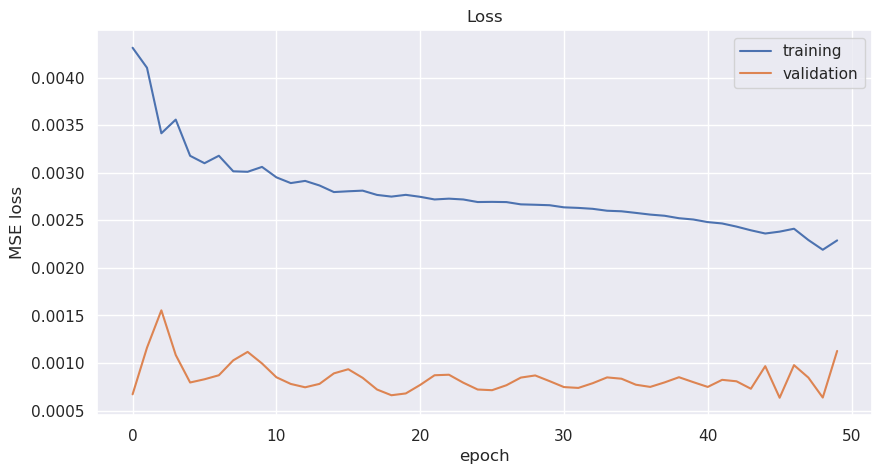

In [21]:
# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

# save figure
# plt.savefig(f'../../figs/{model_name}_loss.png', dpi=300)

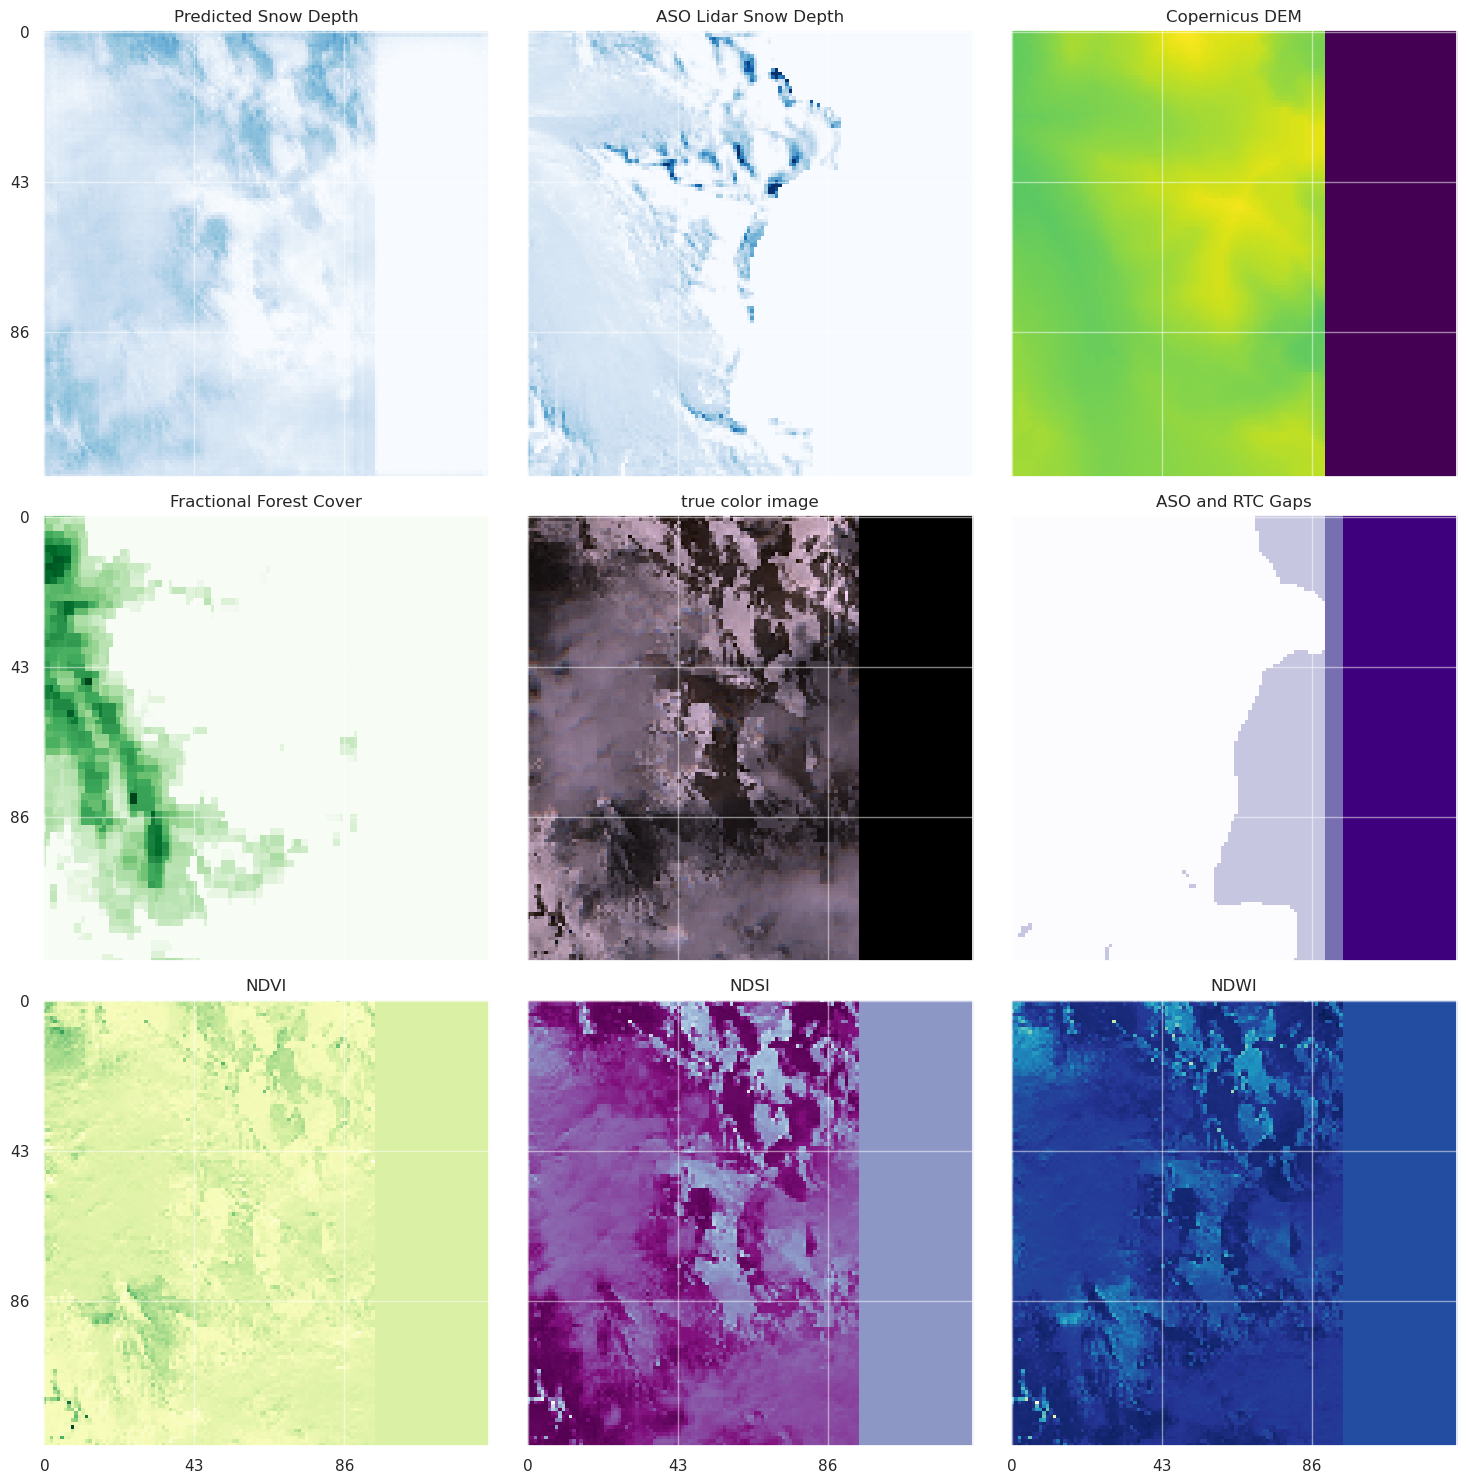

In [22]:
# visualize model predictions
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze() + data_dict['s2_gap_map'].squeeze(), cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        f.tight_layout()
    else:
        break


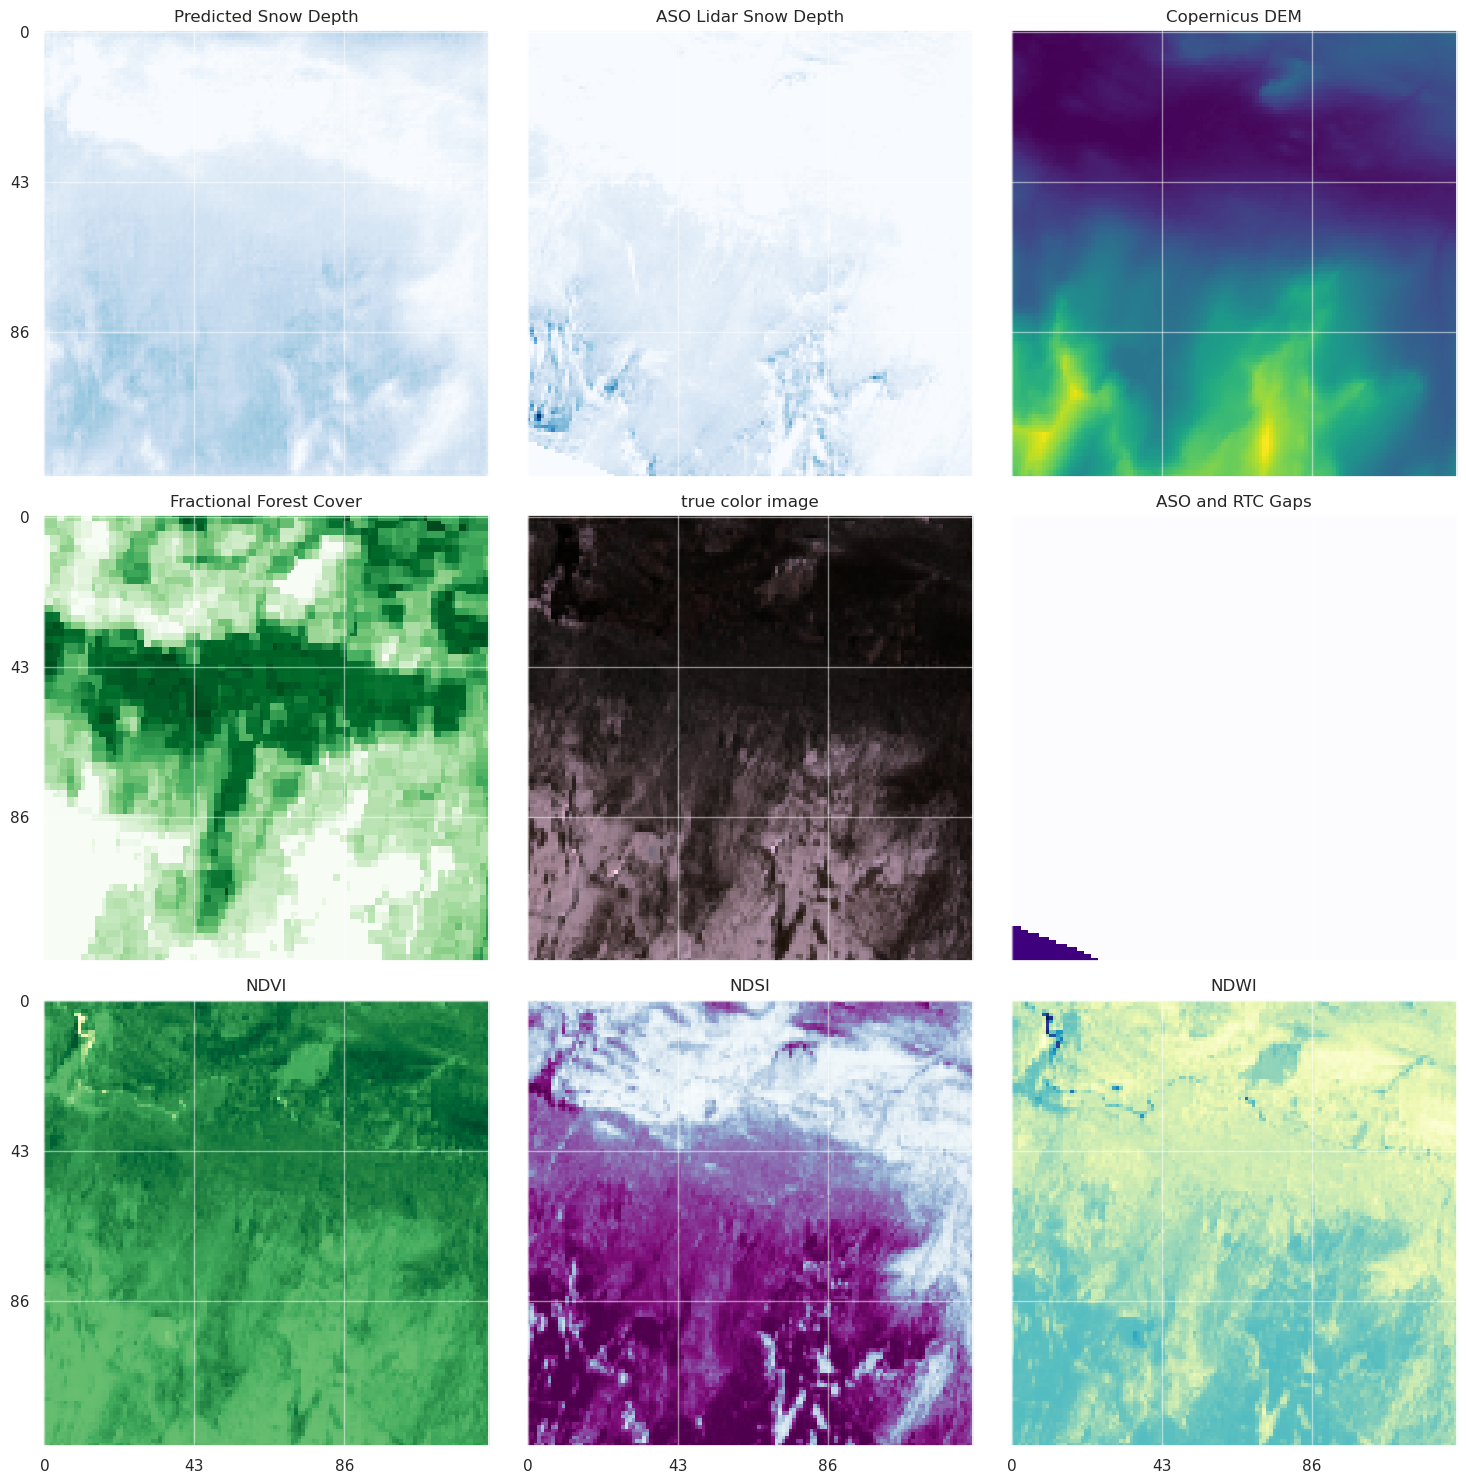

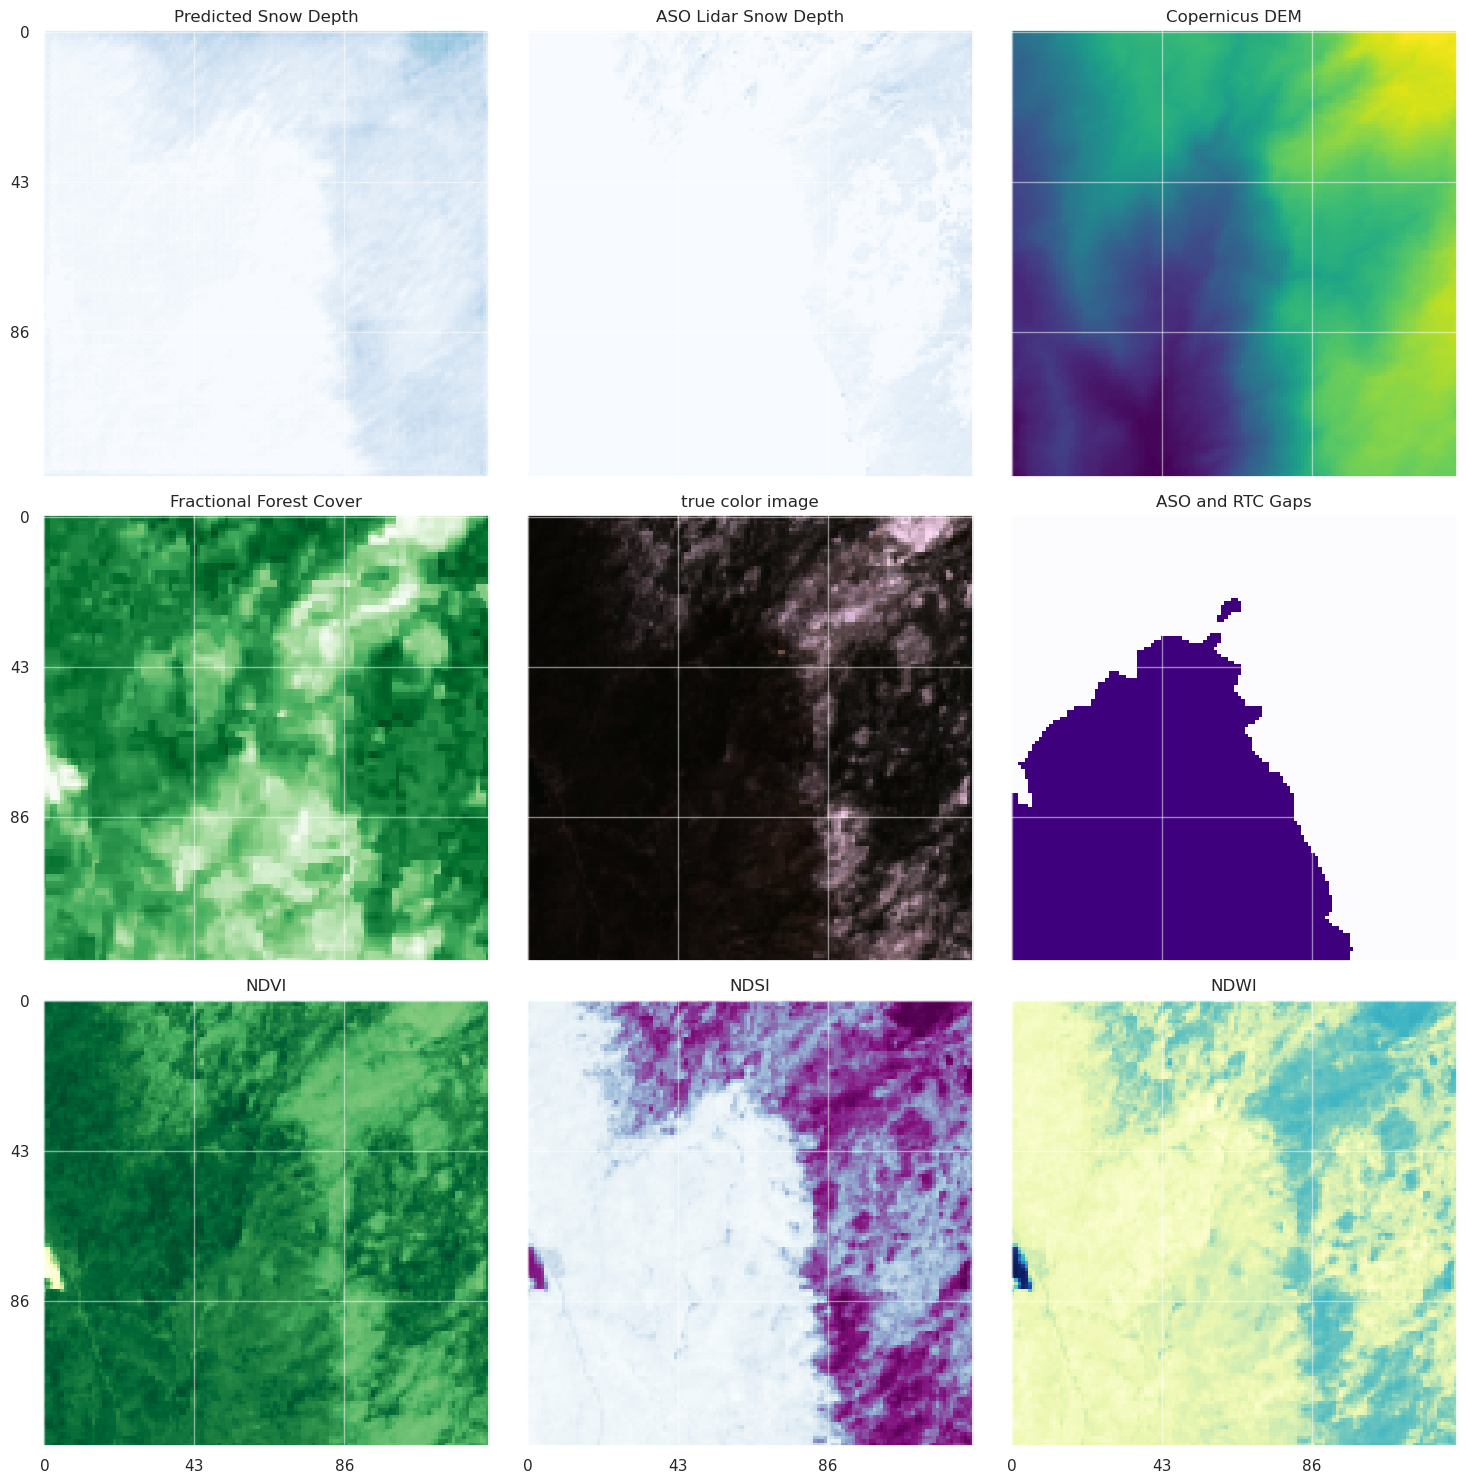

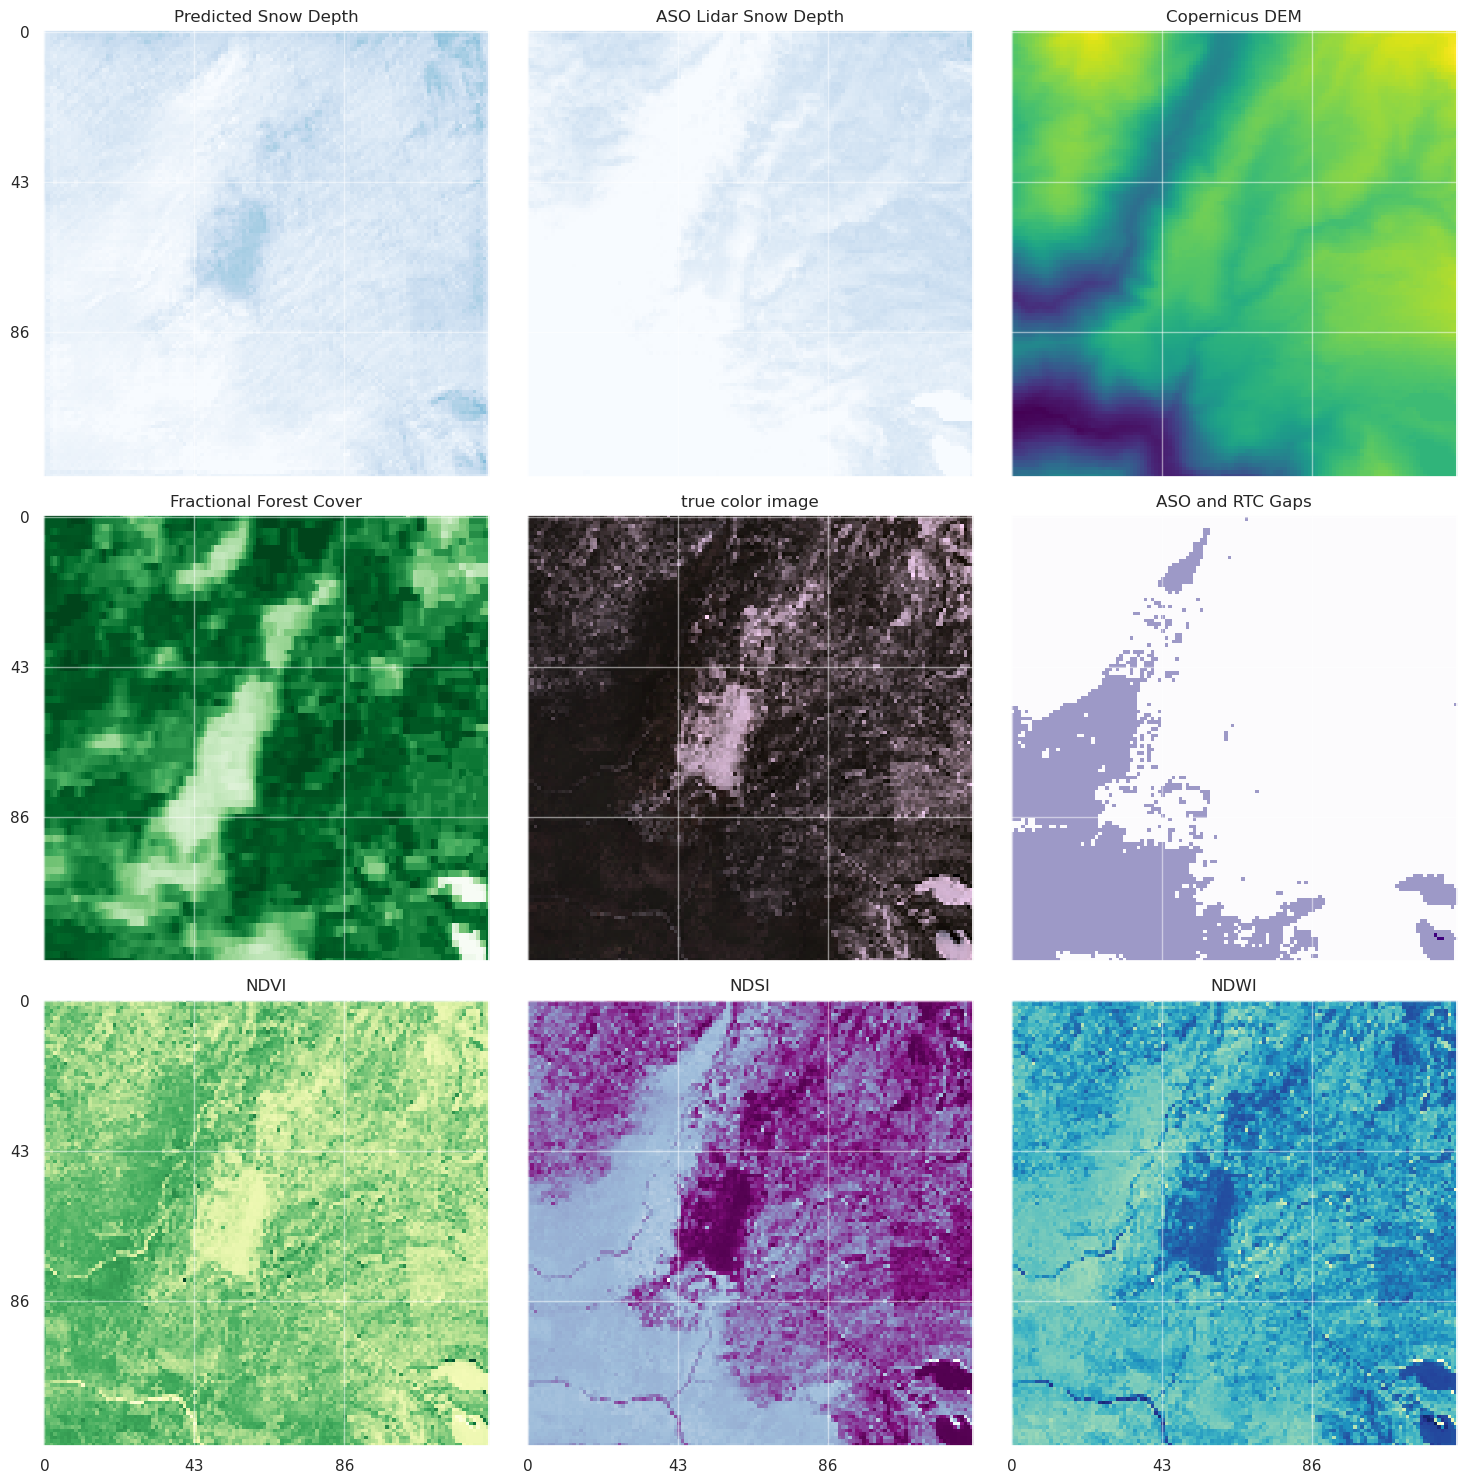

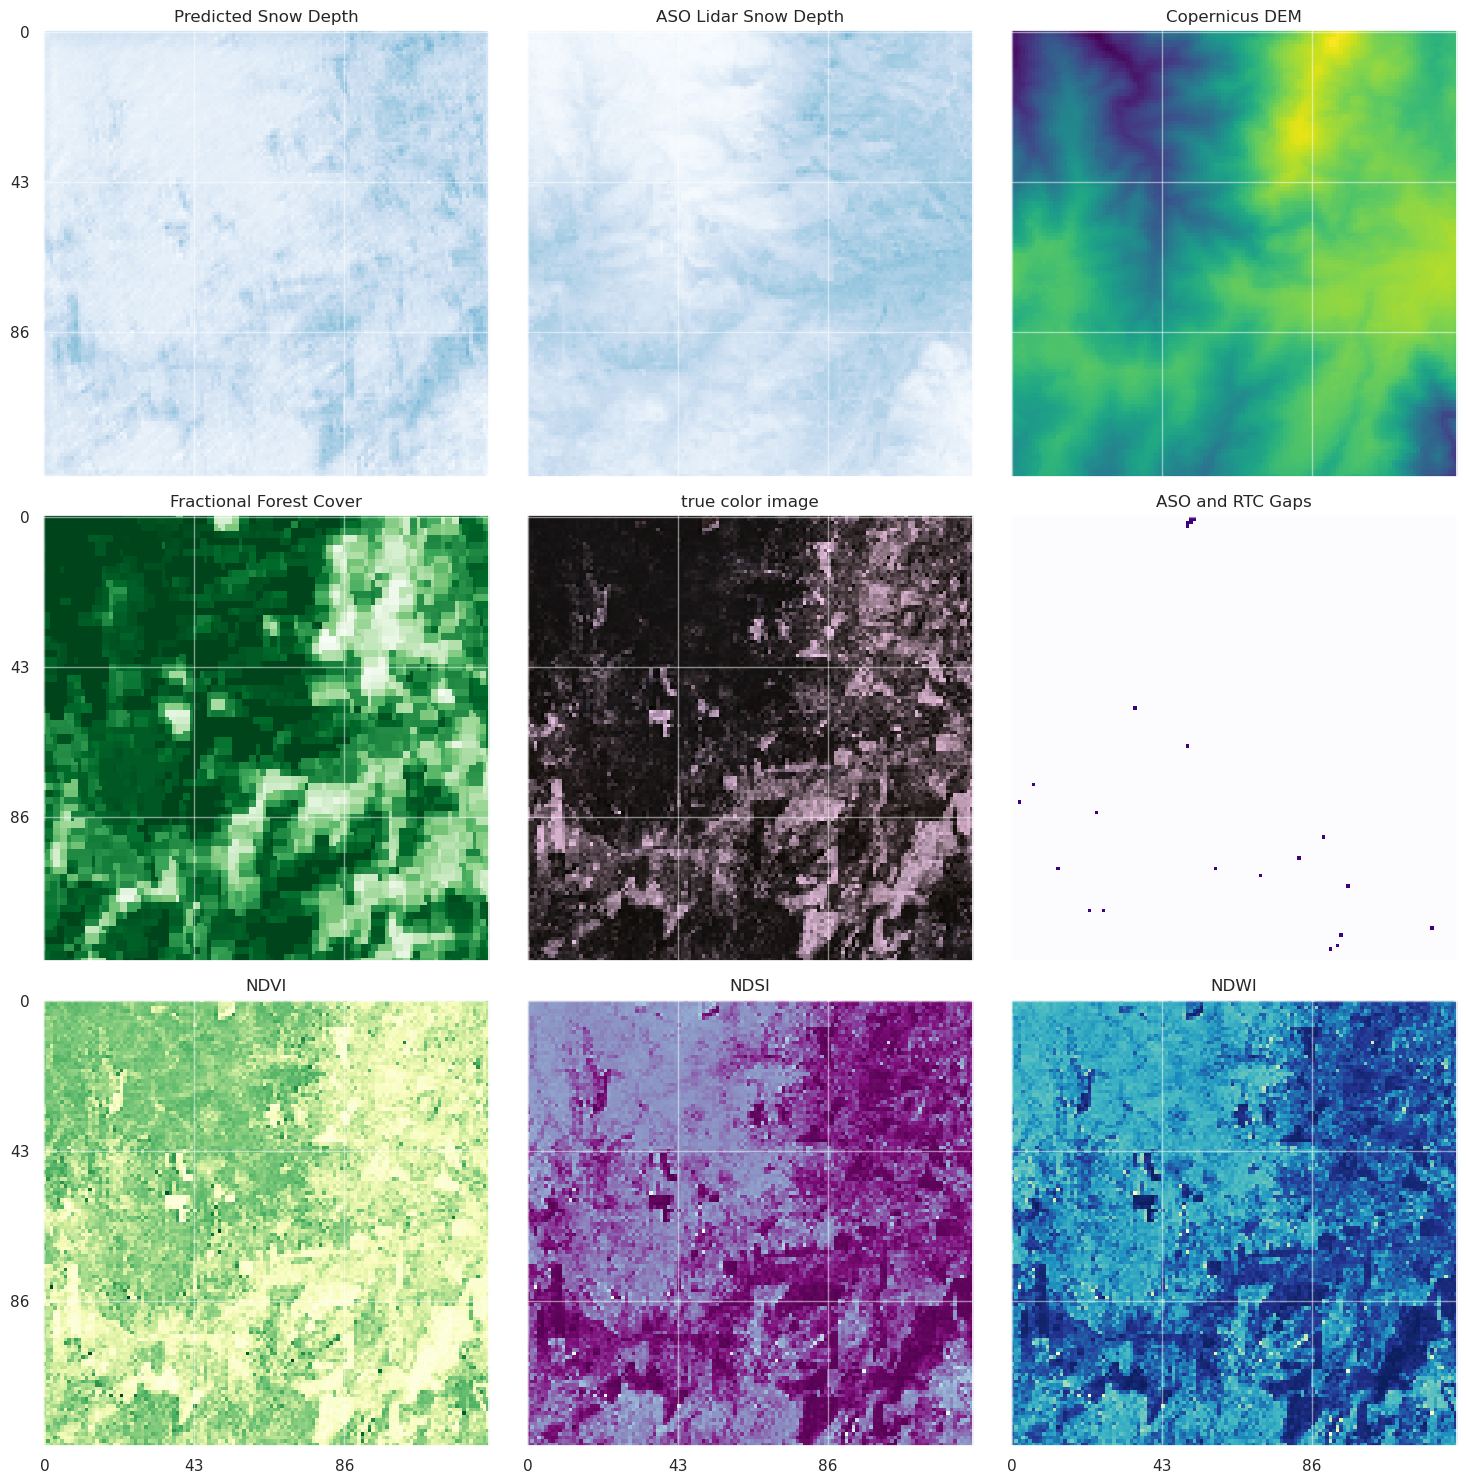

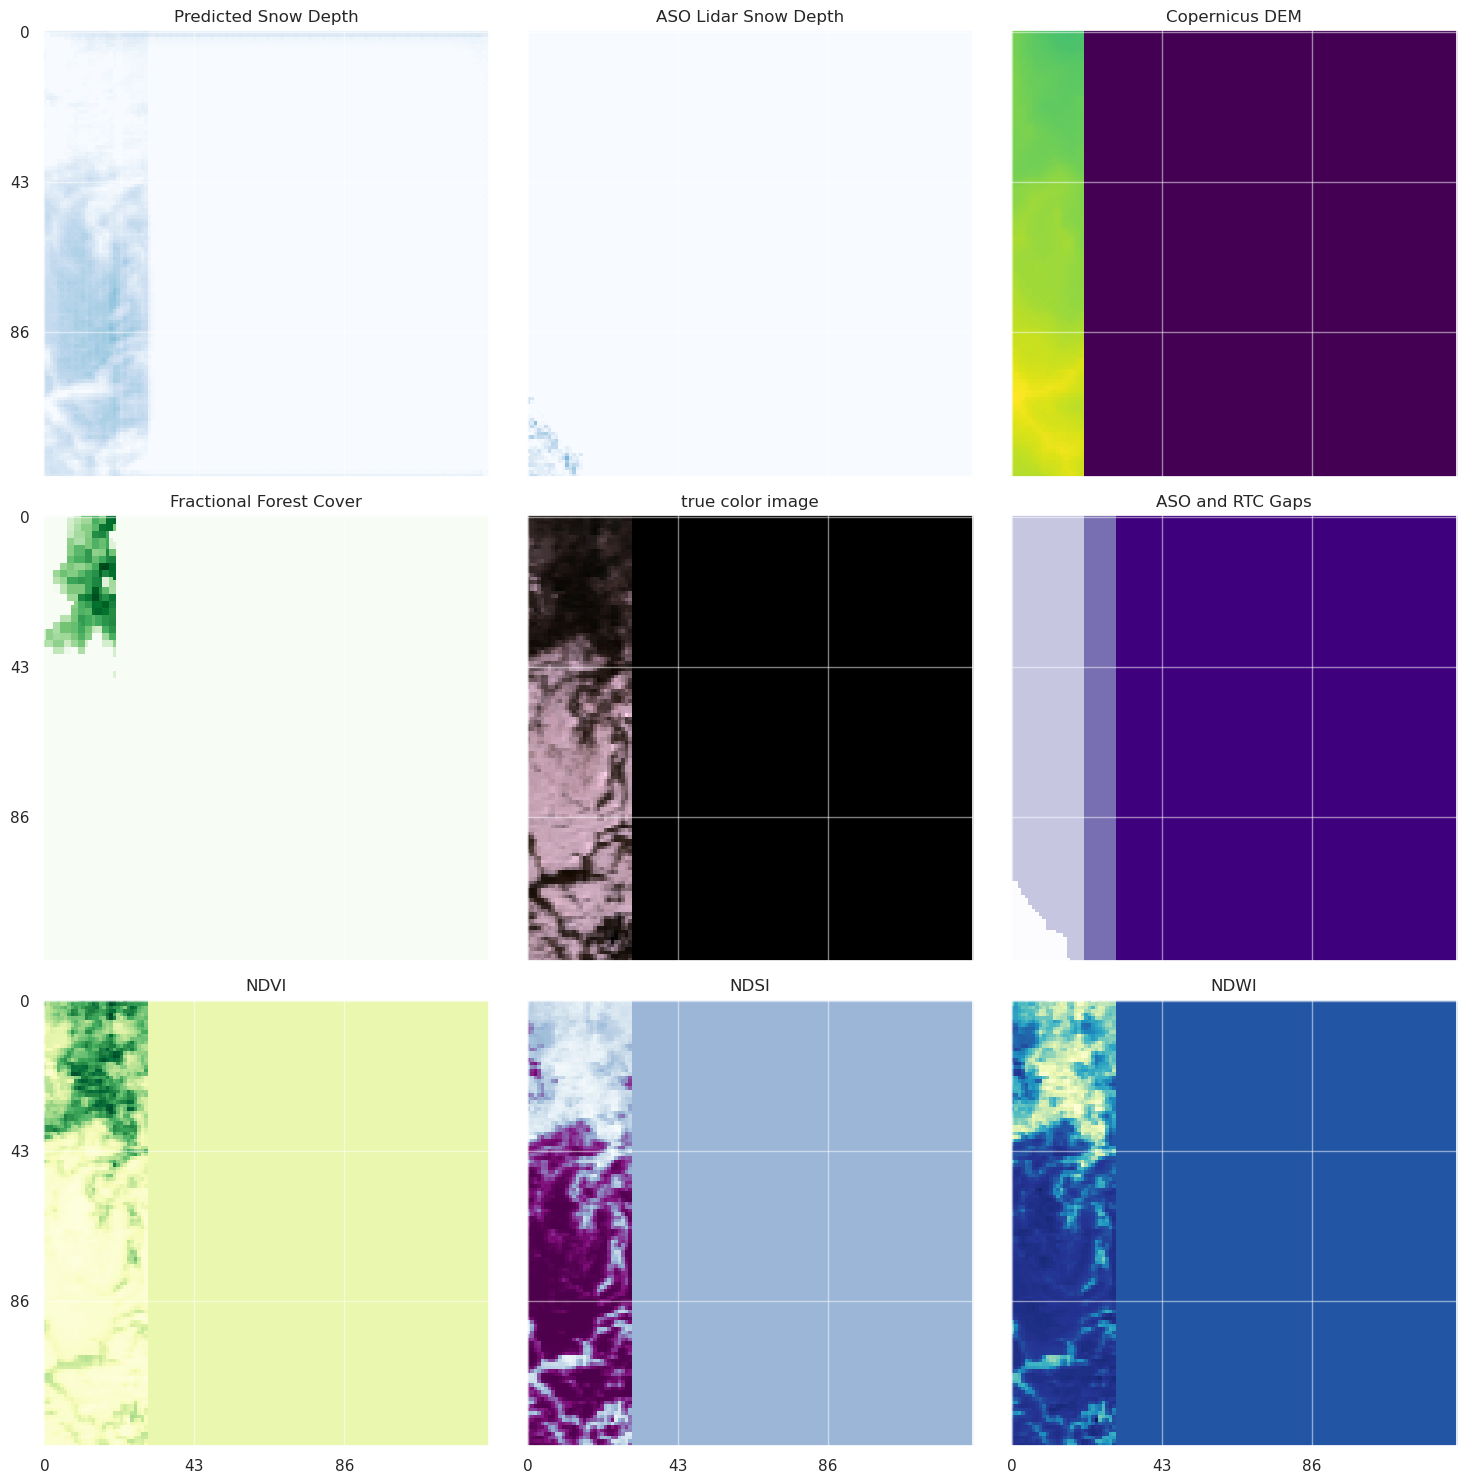

In [24]:
# visualize model predictions
sns.set_theme()
num_samples = 5

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze() + data_dict['s2_gap_map'].squeeze(), cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        f.tight_layout()
    else:
        break


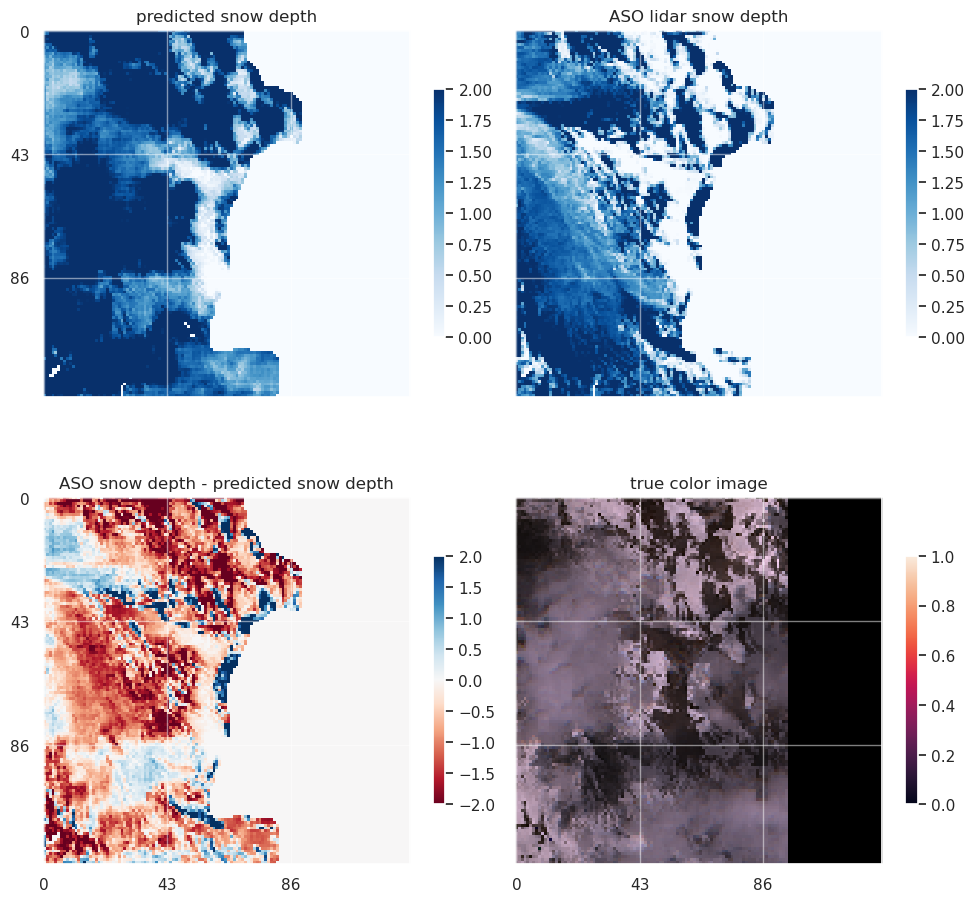

In [23]:
# visualize prediction error
sns.set_theme()
num_samples = 1
norm_dict = crunchy_snow.dataset.norm_dict

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-2, vmax=2, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            f.colorbar(im3, shrink=0.5)

            # modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            plt.tight_layout()
    else: 
        break

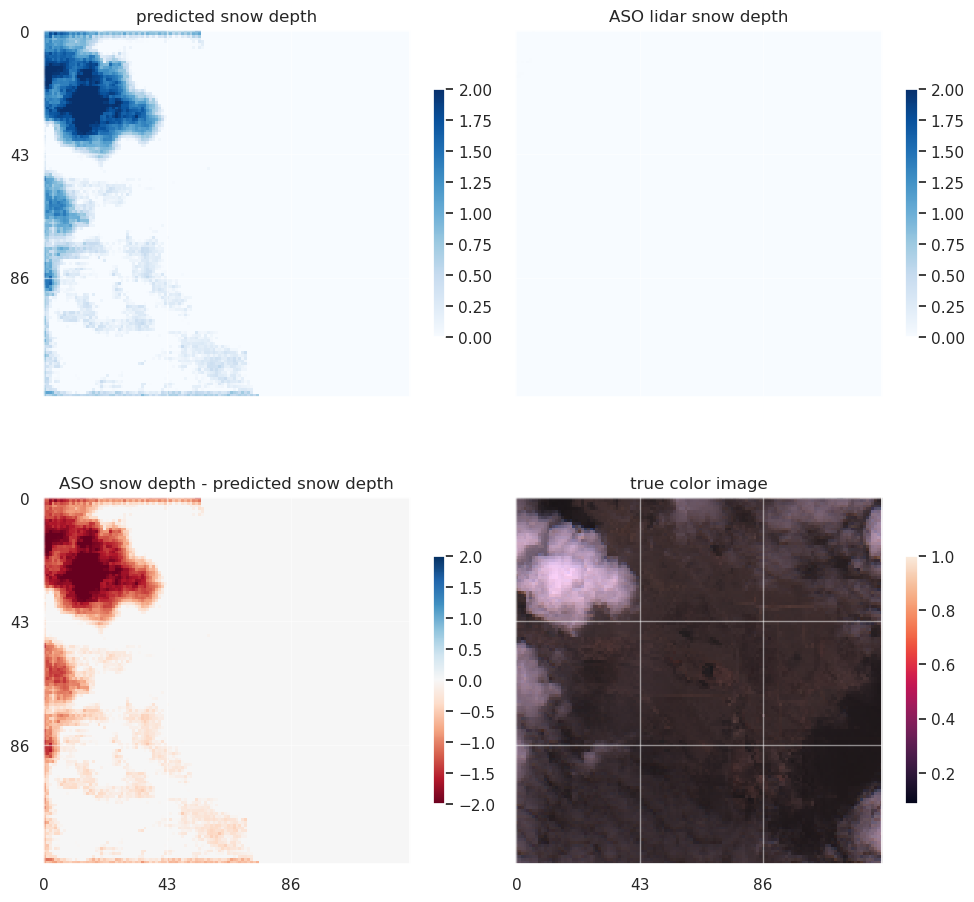

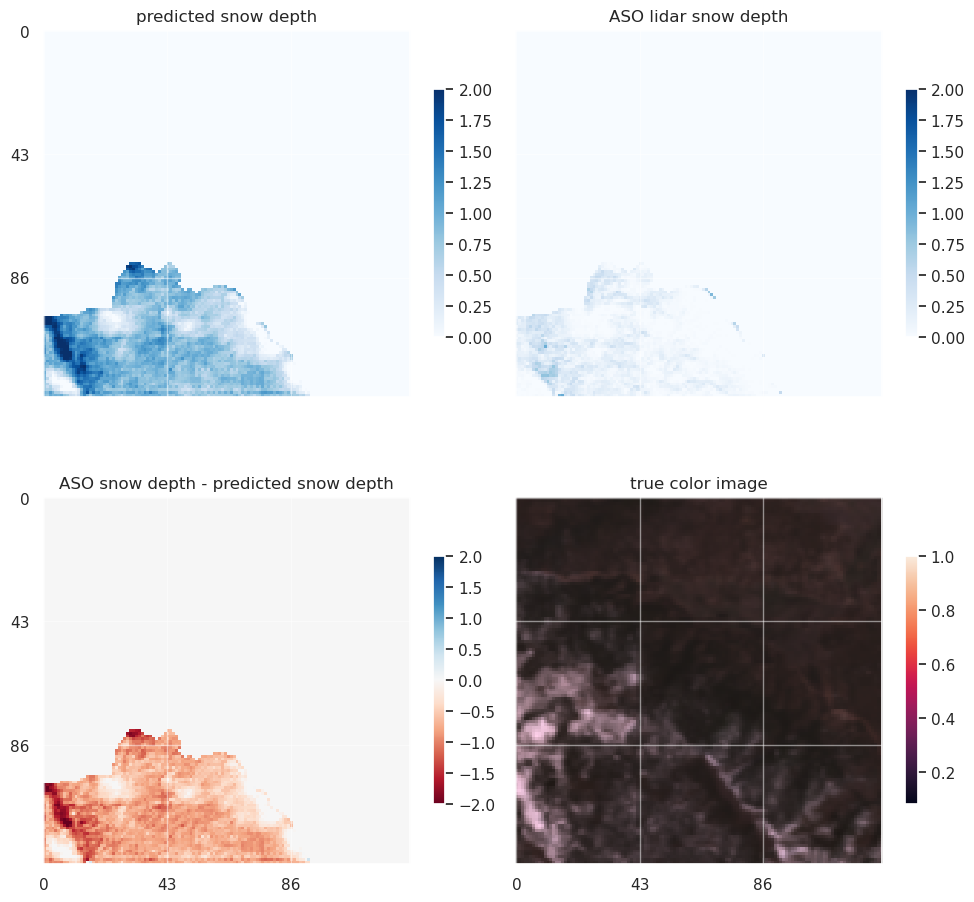

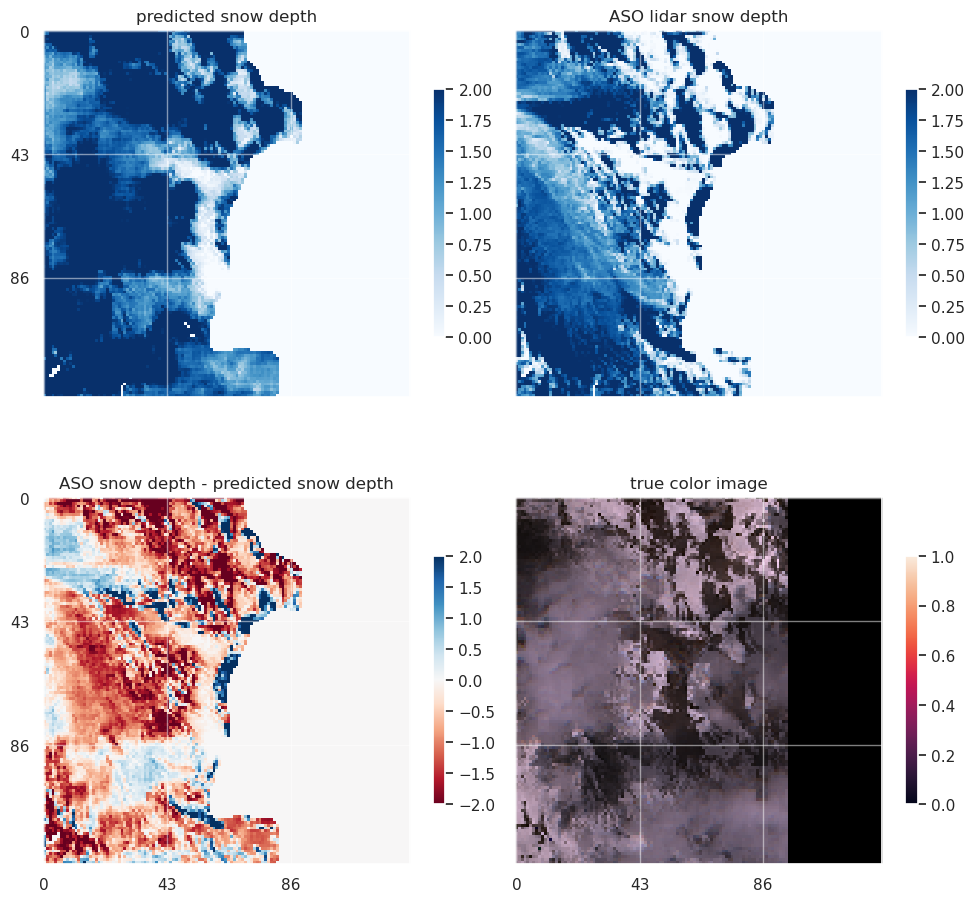

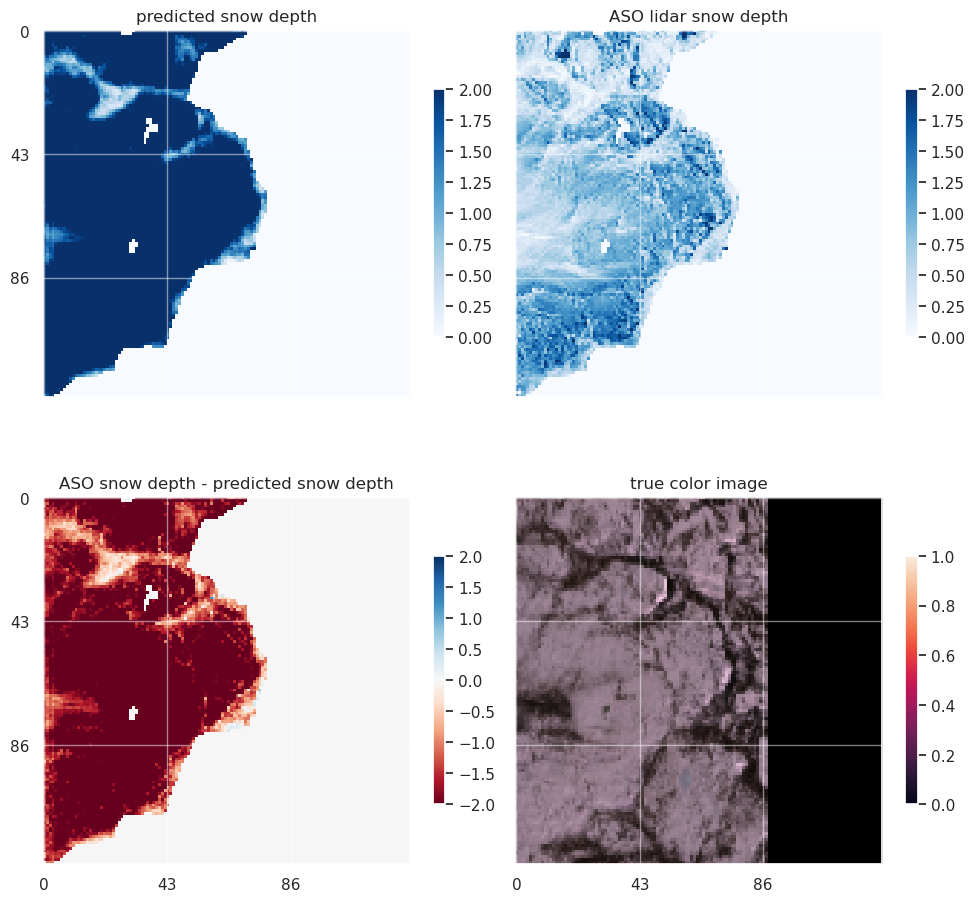

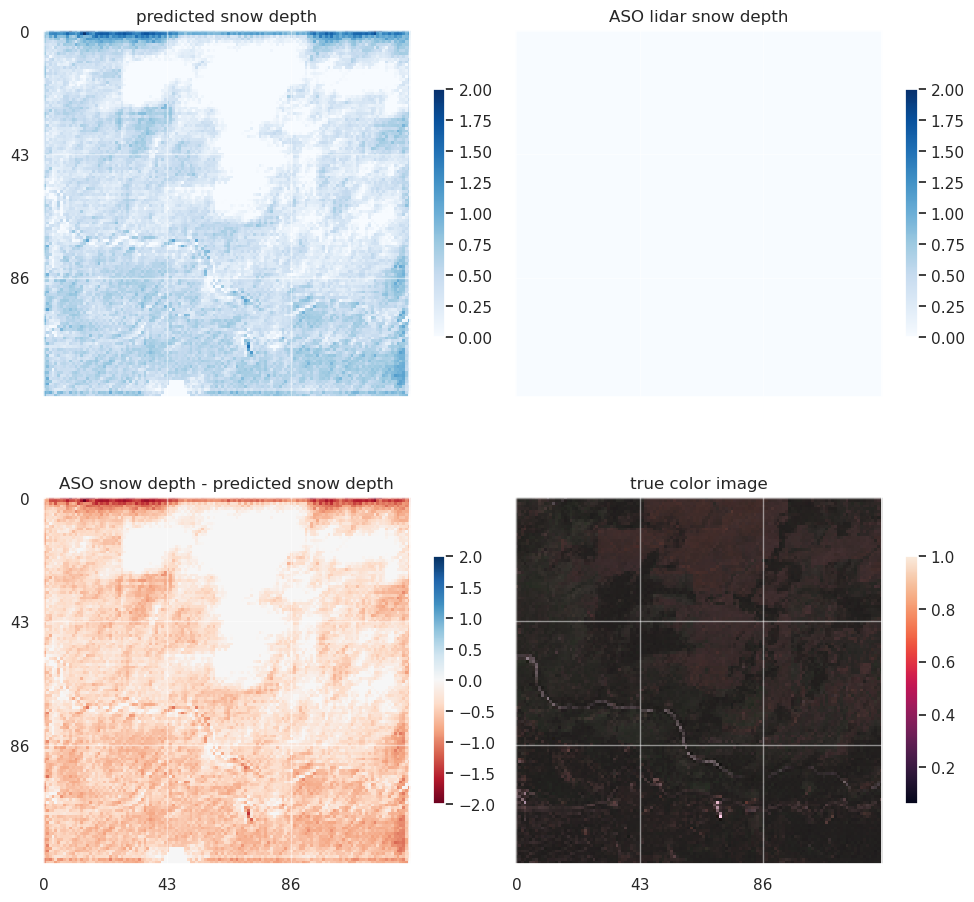

In [25]:
# visualize prediction error
sns.set_theme()
num_samples = 5
norm_dict = crunchy_snow.dataset.norm_dict

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-2, vmax=2, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            f.colorbar(im3, shrink=0.5)

            # modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            plt.tight_layout()
    else: 
        break

## Clouds appear to be an issue

In [26]:
## Learning rate of 0.0001
# Define optimizer and loss function
#hyperparameters: Learning rate, num_epochs, loss function etc

optimizer = optim.AdamW(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
epochs = 50

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    epoch_loss = []
    val_temp_loss = []

    # Loop through training data with tqdm progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in pbar:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        # prepare inputs by concatenating along channel dimension
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')

        # generate prediction
        pred_sd = model(inputs)

        # Limit prediction to areas with valid data
        pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
        aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

        # Calculate loss
        loss = loss_fn(pred_sd, aso_sd.to('cuda'))
        epoch_loss.append(loss.item())

        # Update tqdm progress bar with batch loss
        pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})


        loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(epoch_loss))
    print(f'Training loss: {np.mean(epoch_loss)}')

    # Run model on validation data with tqdm progress bar
    for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            val_temp_loss.append(loss.item())

    val_loss.append(np.mean(val_temp_loss))
    print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # # save model
    # torch.save(model.state_dict(), f'../../../weights/{model_name}')

    # # save loss 
    # with open(f'../../../loss/{model_name}_val_loss.pkl', 'wb') as f:
    #     pickle.dump(val_loss, f)
        
    # with open(f'../../../loss/{model_name}_train_loss.pkl', 'wb') as f:
    #     pickle.dump(train_loss, f)


Starting epoch 1


Epoch 1/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch, batch loss=0.00228, mean epoch loss=0.00228]


Training loss: 0.0022849896922707558


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.58batch/s]


Validation loss: 0.0006719292175603186

Starting epoch 2


Epoch 2/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.40s/batch, batch loss=0.00282, mean epoch loss=0.00282]


Training loss: 0.002824560273438692


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.36batch/s]


Validation loss: 0.0006498202988041157

Starting epoch 3


Epoch 3/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.0022312700748443604


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.59batch/s]


Validation loss: 0.000988983242791619

Starting epoch 4


Epoch 4/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.0021703888196498156


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.52batch/s]


Validation loss: 0.001313033711880962

Starting epoch 5


Epoch 5/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch, batch loss=0.00242, mean epoch loss=0.00242]


Training loss: 0.0024223250802606344


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.83batch/s]


Validation loss: 0.0012355441406270984

Starting epoch 6


Epoch 6/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch, batch loss=0.00235, mean epoch loss=0.00235]


Training loss: 0.0023475484922528267


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.76batch/s]


Validation loss: 0.0009524926888389018

Starting epoch 7


Epoch 7/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.002139533869922161


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.67batch/s]


Validation loss: 0.0007187340327163838

Starting epoch 8


Epoch 8/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.39s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.0021051515359431505


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.64batch/s]


Validation loss: 0.0006266119141855597

Starting epoch 9


Epoch 9/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.40s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.0022293999791145325


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.60batch/s]


Validation loss: 0.0006190401581989136

Starting epoch 10


Epoch 10/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch, batch loss=0.00225, mean epoch loss=0.00225]


Training loss: 0.0022522418294101954


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.63batch/s]


Validation loss: 0.000661285422097535

Starting epoch 11


Epoch 11/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.41s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.0021369082387536764


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.69batch/s]


Validation loss: 0.0007722087575530168

Starting epoch 12


Epoch 12/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.40s/batch, batch loss=0.00206, mean epoch loss=0.00206]


Training loss: 0.0020557399839162827


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.69batch/s]


Validation loss: 0.0009240545537068101

Starting epoch 13


Epoch 13/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch, batch loss=0.00209, mean epoch loss=0.00209]


Training loss: 0.0020916778594255447


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.76batch/s]


Validation loss: 0.0010240371459531161

Starting epoch 14


Epoch 14/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch, batch loss=0.00215, mean epoch loss=0.00215]


Training loss: 0.0021474151872098446


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.62batch/s]


Validation loss: 0.0010034888401833086

Starting epoch 15


Epoch 15/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch, batch loss=0.00212, mean epoch loss=0.00212]


Training loss: 0.002123309765011072


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.74batch/s]


Validation loss: 0.0008868385554023916

Starting epoch 16


Epoch 16/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.53s/batch, batch loss=0.00204, mean epoch loss=0.00204]


Training loss: 0.0020417259074747562


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.66batch/s]


Validation loss: 0.0007553672866151828

Starting epoch 17


Epoch 17/50: 100%|██████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.0019990054424852133


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.74batch/s]


Validation loss: 0.0006743808860392164

Starting epoch 18


Epoch 18/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.42s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.0020339691545814276


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.64batch/s]


Validation loss: 0.000654459191650858

Starting epoch 19


Epoch 19/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.40s/batch, batch loss=0.00205, mean epoch loss=0.00205]


Training loss: 0.002048061229288578


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.54batch/s]


Validation loss: 0.000686180823322502

Starting epoch 20


Epoch 20/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.54s/batch, batch loss=0.00198, mean epoch loss=0.00198]


Training loss: 0.001983162248507142


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.59batch/s]


Validation loss: 0.0007742074971019974

Starting epoch 21


Epoch 21/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019343793392181396


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.36batch/s]


Validation loss: 0.0008789227250645126

Starting epoch 22


Epoch 22/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.0019544821698218584


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.49batch/s]


Validation loss: 0.0009069310985978518

Starting epoch 23


Epoch 23/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.52s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.0019530602730810642


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.51batch/s]


Validation loss: 0.0008249552253118964

Starting epoch 24


Epoch 24/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018891823710873723


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.54batch/s]


Validation loss: 0.0007128815242367637

Starting epoch 25


Epoch 25/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.42s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018606232479214668


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.59batch/s]


Validation loss: 0.0006613142064679778

Starting epoch 26


Epoch 26/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.0018788508605211973


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.57batch/s]


Validation loss: 0.0006856469783542707

Starting epoch 27


Epoch 27/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.52s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018215012969449162


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.51batch/s]


Validation loss: 0.0007758208014365664

Starting epoch 28


Epoch 28/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.0017889696173369884


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.40batch/s]


Validation loss: 0.0008285829970873237

Starting epoch 29


Epoch 29/50: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0017996556125581264


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.61batch/s]


Validation loss: 0.0007418718237204303

Starting epoch 30


Epoch 30/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.50s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.0017309996765106916


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.56batch/s]


Validation loss: 0.0006490960136034118

Starting epoch 31


Epoch 31/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.50s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.0017287435475736856


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.50batch/s]


Validation loss: 0.0006509066240596439

Starting epoch 32


Epoch 32/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016893723513931036


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.38batch/s]


Validation loss: 0.0007309636075660819

Starting epoch 33


Epoch 33/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.42s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016577120404690504


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.49batch/s]


Validation loss: 0.000728589678260505

Starting epoch 34


Epoch 34/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016361535526812077


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.67batch/s]


Validation loss: 0.0006357662638265538

Starting epoch 35


Epoch 35/50: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0015996008878573775


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.55batch/s]


Validation loss: 0.0006305590894726265

Starting epoch 36


Epoch 36/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.001569416024722159


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.64batch/s]


Validation loss: 0.0006923959244886646

Starting epoch 37


Epoch 37/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015582795022055507


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.79batch/s]


Validation loss: 0.0006429330160244717

Starting epoch 38


Epoch 38/50: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0015030420618131757


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.74batch/s]


Validation loss: 0.0005982307276326537

Starting epoch 39


Epoch 39/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.40s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.001510215108282864


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.55batch/s]


Validation loss: 0.0006243475020255573

Starting epoch 40


Epoch 40/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.001459852559491992


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.63batch/s]


Validation loss: 0.0006377237918968603

Starting epoch 41


Epoch 41/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.50s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.001464265864342451


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.64batch/s]


Validation loss: 0.0005760039491633506

Starting epoch 42


Epoch 42/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.001455062534660101


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.64batch/s]


Validation loss: 0.0005801164522836189

Starting epoch 43


Epoch 43/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.42s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014235953567549586


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.69batch/s]


Validation loss: 0.0006305134552349045

Starting epoch 44


Epoch 44/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014347487594932318


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.62batch/s]


Validation loss: 0.0005779306738986634

Starting epoch 45


Epoch 45/50: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013970588333904743


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.59batch/s]


Validation loss: 0.0005661614844711949

Starting epoch 46


Epoch 46/50: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014017729554325342


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.72batch/s]


Validation loss: 0.0005960001005860249

Starting epoch 47


Epoch 47/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.51s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.001371414982713759


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.62batch/s]


Validation loss: 0.0006146461686284965

Starting epoch 48


Epoch 48/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.001383087132126093


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.66batch/s]


Validation loss: 0.0005616090130615703

Starting epoch 49


Epoch 49/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013677821261808276


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.63batch/s]


Validation loss: 0.0005593730123791829

Starting epoch 50


Epoch 50/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.51s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013648226158693433


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.55batch/s]

Validation loss: 0.0006052505103752992


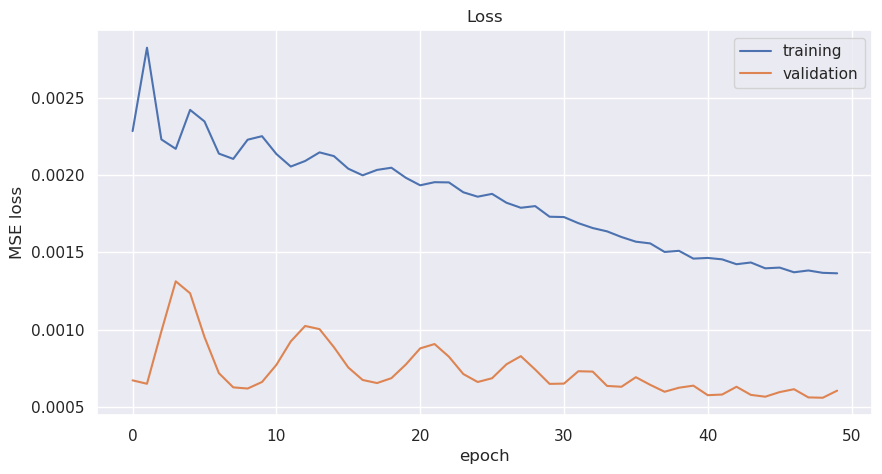

In [27]:
# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

# save figure
# plt.savefig(f'../../figs/{model_name}_loss.png', dpi=300)

/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


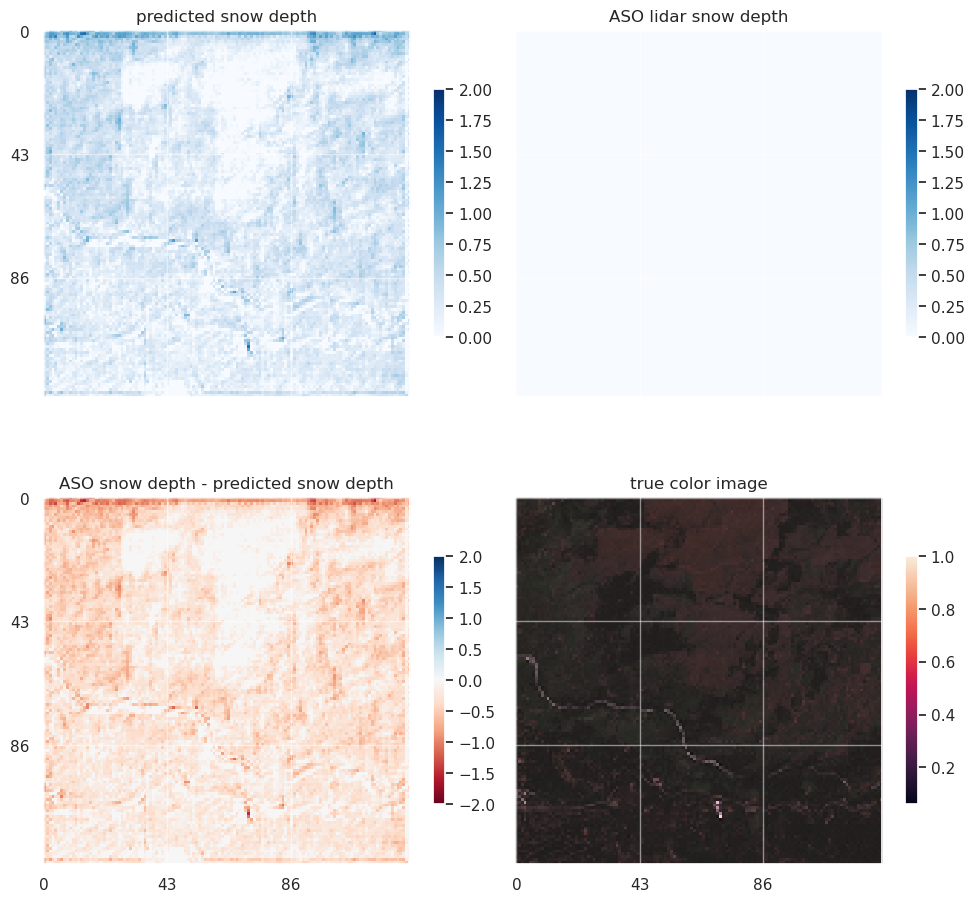

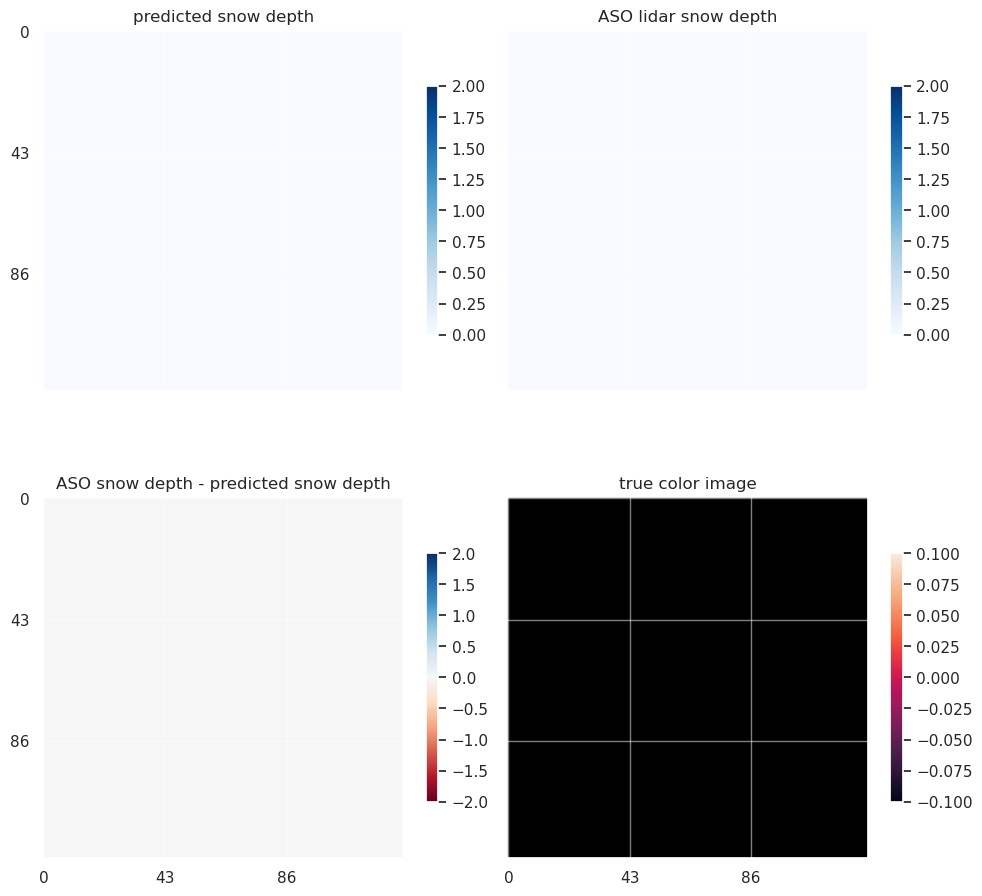

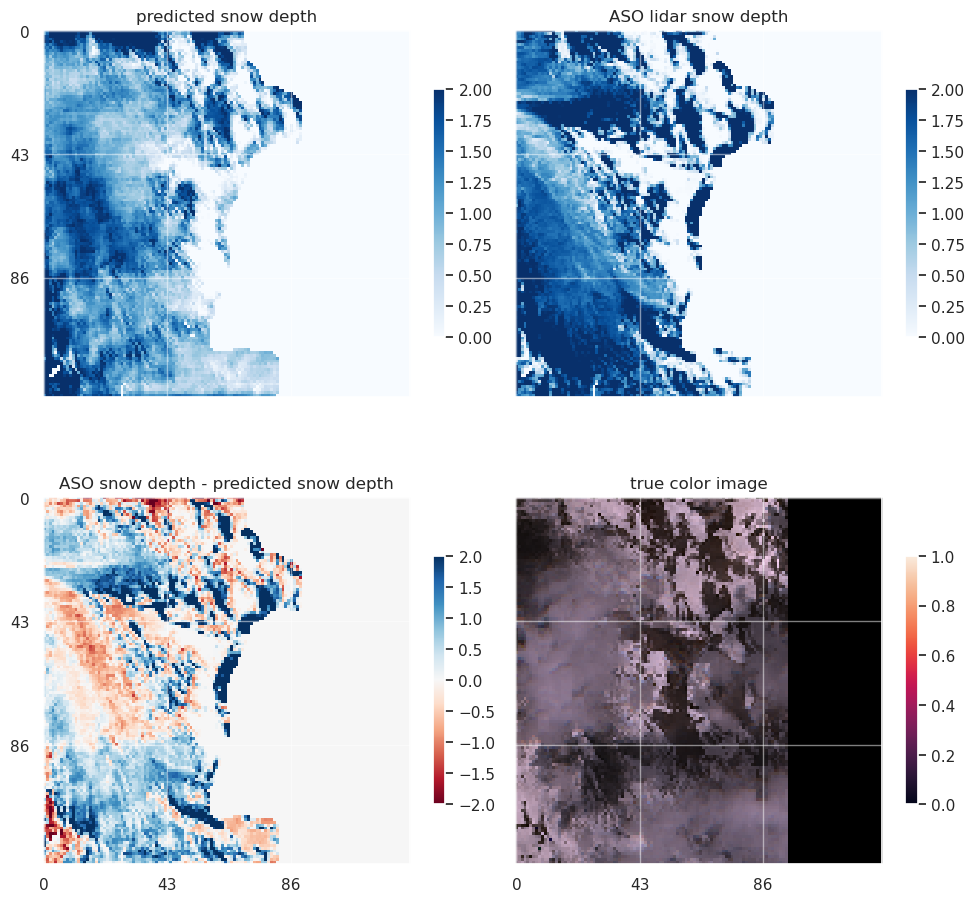

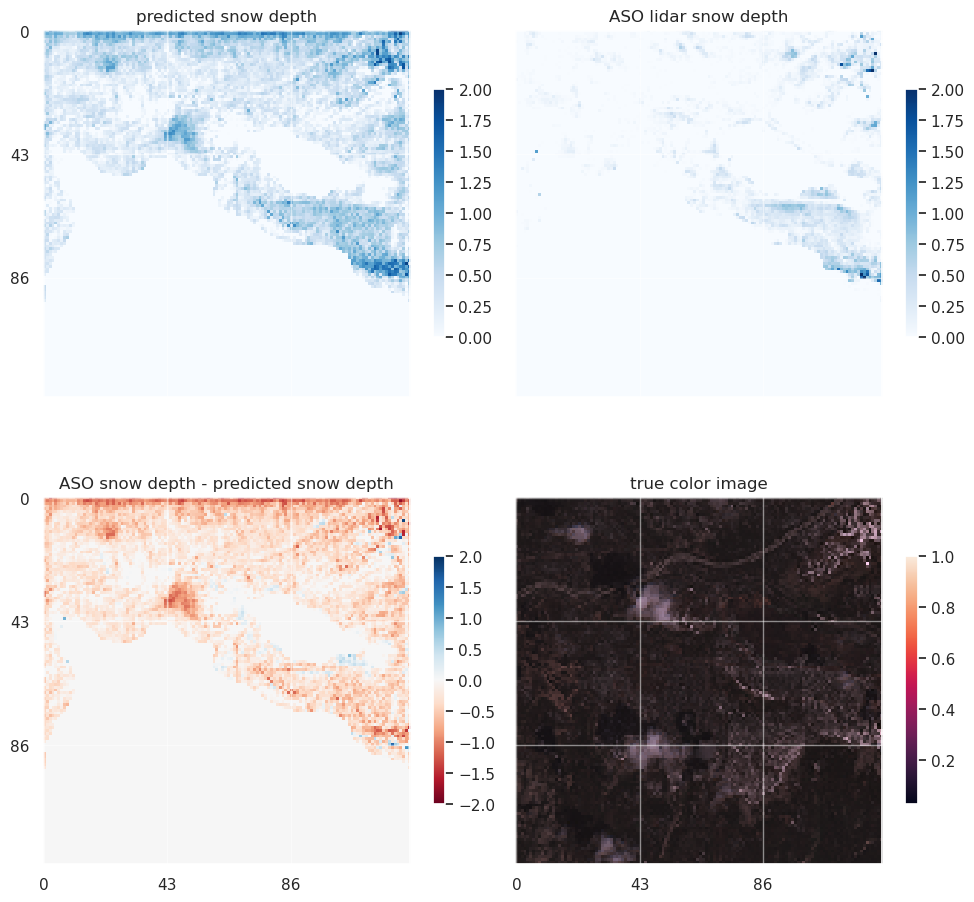

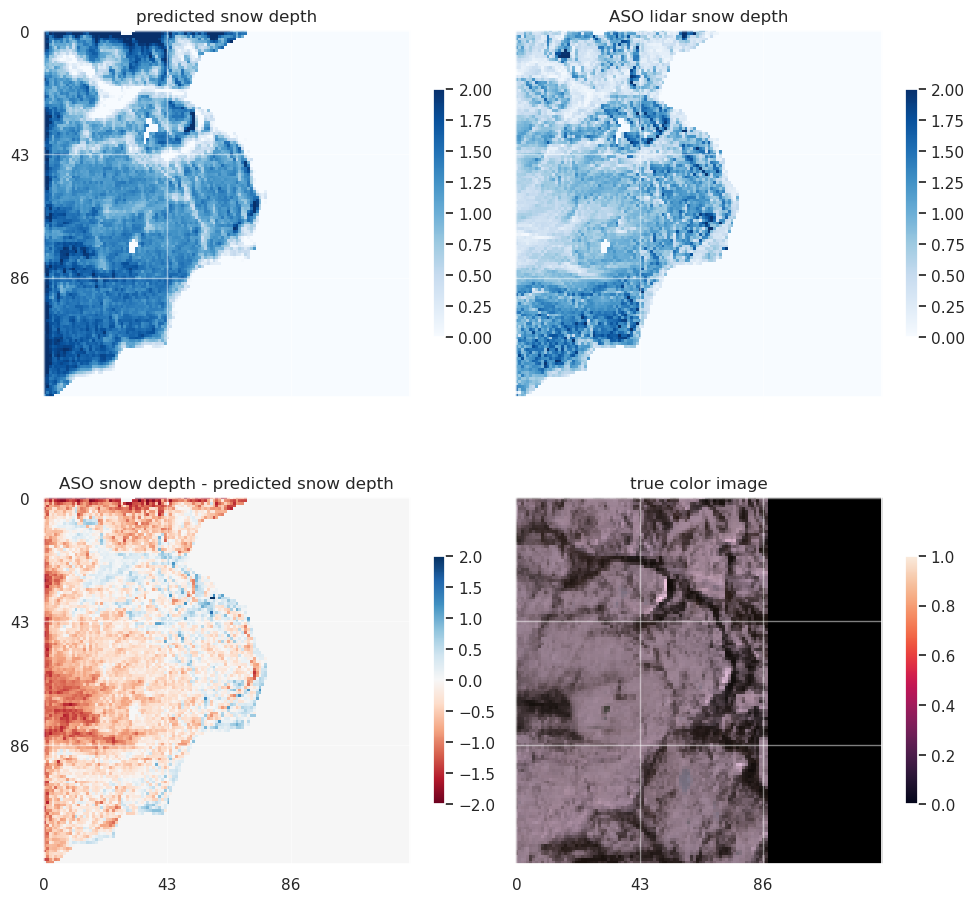

In [28]:
# visualize prediction error
sns.set_theme()
num_samples = 5
norm_dict = crunchy_snow.dataset.norm_dict

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-2, vmax=2, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            f.colorbar(im3, shrink=0.5)

            # modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            plt.tight_layout()
    else: 
        break

In [29]:
## Learning rate of 0.0001
# Define optimizer and loss function
#hyperparameters: Learning rate, num_epochs, loss function etc

optimizer = optim.AdamW(model.parameters(), lr=0.000001)
loss_fn = nn.MSELoss()
epochs = 50

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    epoch_loss = []
    val_temp_loss = []

    # Loop through training data with tqdm progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in pbar:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        # prepare inputs by concatenating along channel dimension
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')

        # generate prediction
        pred_sd = model(inputs)

        # Limit prediction to areas with valid data
        pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
        aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

        # Calculate loss
        loss = loss_fn(pred_sd, aso_sd.to('cuda'))
        epoch_loss.append(loss.item())

        # Update tqdm progress bar with batch loss
        pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})


        loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(epoch_loss))
    print(f'Training loss: {np.mean(epoch_loss)}')

    # Run model on validation data with tqdm progress bar
    for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            val_temp_loss.append(loss.item())

    val_loss.append(np.mean(val_temp_loss))
    print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # # save model
    # torch.save(model.state_dict(), f'../../../weights/{model_name}')

    # # save loss 
    # with open(f'../../../loss/{model_name}_val_loss.pkl', 'wb') as f:
    #     pickle.dump(val_loss, f)
        
    # with open(f'../../../loss/{model_name}_train_loss.pkl', 'wb') as f:
    #     pickle.dump(train_loss, f)


Starting epoch 1


Epoch 1/50: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.03s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013476151507347822


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.88batch/s]


Validation loss: 0.000599034143647259

Starting epoch 2


Epoch 2/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013432357227429748


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.63batch/s]


Validation loss: 0.0005933426906494788

Starting epoch 3


Epoch 3/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013403443153947592


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.52batch/s]


Validation loss: 0.0005882816134317181

Starting epoch 4


Epoch 4/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013388360384851694


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.47batch/s]


Validation loss: 0.0005840366595748492

Starting epoch 5


Epoch 5/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.001338463043794036


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.47batch/s]


Validation loss: 0.0005807669944033478

Starting epoch 6


Epoch 6/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013387497747316957


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.40batch/s]


Validation loss: 0.0005785274190657219

Starting epoch 7


Epoch 7/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.001339224399998784


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.09batch/s]


Validation loss: 0.000577258418729798

Starting epoch 8


Epoch 8/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013395571149885654


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.09batch/s]


Validation loss: 0.0005768377778849754

Starting epoch 9


Epoch 9/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.001339587732218206


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.01batch/s]


Validation loss: 0.0005771127032403456

Starting epoch 10


Epoch 10/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013393128756433725


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.01batch/s]


Validation loss: 0.0005779426957133182

Starting epoch 11


Epoch 11/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013388138031587005


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.11batch/s]


Validation loss: 0.0005791988692180894

Starting epoch 12


Epoch 12/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.07batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013382051838561893


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.25batch/s]


Validation loss: 0.000580762082563524

Starting epoch 13


Epoch 13/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.08batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013375976122915745


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.27batch/s]


Validation loss: 0.0005825202039204669

Starting epoch 14


Epoch 14/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013370768865570426


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.83batch/s]


Validation loss: 0.0005843537370537888

Starting epoch 15


Epoch 15/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013366920175030828


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.00batch/s]


Validation loss: 0.0005861391863390963

Starting epoch 16


Epoch 16/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.001336453715339303


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.03batch/s]


Validation loss: 0.0005877531407350034

Starting epoch 17


Epoch 17/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013363398611545563


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.82batch/s]


Validation loss: 0.0005890882936228081

Starting epoch 18


Epoch 18/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.09batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013362900353968143


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.29batch/s]


Validation loss: 0.0005900560925056197

Starting epoch 19


Epoch 19/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.08batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013362406753003597


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.01batch/s]


Validation loss: 0.0005906073831738468

Starting epoch 20


Epoch 20/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.08batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.001336133573204279


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.53batch/s]


Validation loss: 0.0005907358570311771

Starting epoch 21


Epoch 21/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013359395088627934


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.06batch/s]


Validation loss: 0.0005904797802713802

Starting epoch 22


Epoch 22/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013356625568121672


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.11batch/s]


Validation loss: 0.0005899070960140307

Starting epoch 23


Epoch 23/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.07batch/s, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013353305403143167


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.30batch/s]


Validation loss: 0.0005891028707765145

Starting epoch 24


Epoch 24/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.08batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013349833898246288


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.12batch/s]


Validation loss: 0.0005881636426465775

Starting epoch 25


Epoch 25/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.02s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013346578925848007


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.31batch/s]


Validation loss: 0.0005871835121524782

Starting epoch 26


Epoch 26/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.07batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013343761675059795


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.01batch/s]


Validation loss: 0.0005862514950649711

Starting epoch 27


Epoch 27/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013341475278139114


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.47batch/s]


Validation loss: 0.0005854378518961312

Starting epoch 28


Epoch 28/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.07batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013339592842385173


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.16batch/s]


Validation loss: 0.0005848034713835659

Starting epoch 29


Epoch 29/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013337930431589484


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.05batch/s]


Validation loss: 0.0005843892927259731

Starting epoch 30


Epoch 30/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013336243573576212


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.68batch/s]


Validation loss: 0.0005842092314196634

Starting epoch 31


Epoch 31/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013334359973669052


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.79batch/s]


Validation loss: 0.0005842632485837385

Starting epoch 32


Epoch 32/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001333218882791698


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.97batch/s]


Validation loss: 0.0005845339195502675

Starting epoch 33


Epoch 33/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001332973944954574


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.12batch/s]


Validation loss: 0.0005849911619861814

Starting epoch 34


Epoch 34/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.08batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013327104970812798


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.43batch/s]


Validation loss: 0.0005855894585238275

Starting epoch 35


Epoch 35/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013324411120265722


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.07batch/s]


Validation loss: 0.0005862819361937

Starting epoch 36


Epoch 36/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.08batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013321794103831053


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.13batch/s]


Validation loss: 0.0005870112300954133

Starting epoch 37


Epoch 37/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013319344725459814


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.26batch/s]


Validation loss: 0.0005877189378225012

Starting epoch 38


Epoch 38/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013317079283297062


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.31batch/s]


Validation loss: 0.0005883505041310855

Starting epoch 39


Epoch 39/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.07batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013314960524439812


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.13batch/s]


Validation loss: 0.0005888615679623399

Starting epoch 40


Epoch 40/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001331288949586451


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.97batch/s]


Validation loss: 0.0005892231167763384

Starting epoch 41


Epoch 41/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013310775393620133


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.20batch/s]


Validation loss: 0.0005894236708172684

Starting epoch 42


Epoch 42/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.07batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001330855768173933


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.12batch/s]


Validation loss: 0.0005894659395835333

Starting epoch 43


Epoch 43/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013306213077157736


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.05batch/s]


Validation loss: 0.0005893678689972148

Starting epoch 44


Epoch 44/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.08batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013303770683705807


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.89batch/s]


Validation loss: 0.0005891623858360617

Starting epoch 45


Epoch 45/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013301289873197675


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.00batch/s]


Validation loss: 0.0005888911316560552

Starting epoch 46


Epoch 46/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013298837002366781


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.86batch/s]


Validation loss: 0.0005886004303192749

Starting epoch 47


Epoch 47/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013296459801495075


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.58batch/s]


Validation loss: 0.000588332828442617

Starting epoch 48


Epoch 48/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013294150121510029


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.02batch/s]


Validation loss: 0.0005881198767383466

Starting epoch 49


Epoch 49/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.07batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001329188933596015


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.22batch/s]


Validation loss: 0.0005879926742409225

Starting epoch 50


Epoch 50/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.08batch/s, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001328964252024889


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.28batch/s]

Validation loss: 0.0005879680521729824


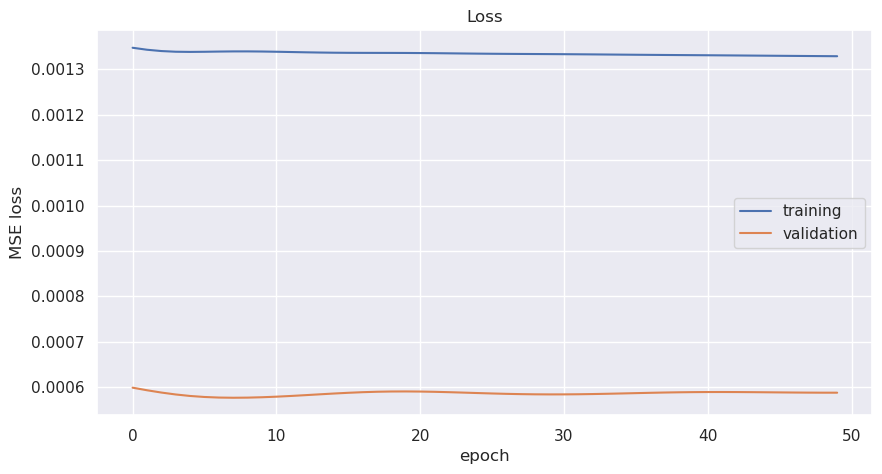

In [30]:
# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

# save figure
# plt.savefig(f'../../figs/{model_name}_loss.png', dpi=300)

In [31]:
## Learning rate of 0.05
# Define optimizer and loss function
#hyperparameters: Learning rate, num_epochs, loss function etc

optimizer = optim.AdamW(model.parameters(), lr=0.000001)
loss_fn = nn.MSELoss()
epochs = 50

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    epoch_loss = []
    val_temp_loss = []

    # Loop through training data with tqdm progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in pbar:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        # prepare inputs by concatenating along channel dimension
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')

        # generate prediction
        pred_sd = model(inputs)

        # Limit prediction to areas with valid data
        pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
        aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

        # Calculate loss
        loss = loss_fn(pred_sd, aso_sd.to('cuda'))
        epoch_loss.append(loss.item())

        # Update tqdm progress bar with batch loss
        pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})


        loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(epoch_loss))
    print(f'Training loss: {np.mean(epoch_loss)}')

    # Run model on validation data with tqdm progress bar
    for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            val_temp_loss.append(loss.item())

    val_loss.append(np.mean(val_temp_loss))
    print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # # save model
    # torch.save(model.state_dict(), f'../../../weights/{model_name}')

    # # save loss 
    # with open(f'../../../loss/{model_name}_val_loss.pkl', 'wb') as f:
    #     pickle.dump(val_loss, f)
        
    # with open(f'../../../loss/{model_name}_train_loss.pkl', 'wb') as f:
    #     pickle.dump(train_loss, f)


Starting epoch 1


Epoch 1/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013287365436553955


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.41batch/s]


Validation loss: 0.0005909510618948843

Starting epoch 2


Epoch 2/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.32s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013284592423588037


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.32batch/s]


Validation loss: 0.0005896999290371241

Starting epoch 3


Epoch 3/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.36s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001328050740994513


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.36batch/s]


Validation loss: 0.0005884416254957614

Starting epoch 4


Epoch 4/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.42s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013277303660288453


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.43batch/s]


Validation loss: 0.0005882421077103572

Starting epoch 5


Epoch 5/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.39s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001327409641817212


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.37batch/s]


Validation loss: 0.0005889043624165424

Starting epoch 6


Epoch 6/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.34s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013270449126139283


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.43batch/s]


Validation loss: 0.0005898748341905957

Starting epoch 7


Epoch 7/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.35s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013266935711726546


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.30batch/s]


Validation loss: 0.000590626391499427

Starting epoch 8


Epoch 8/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.37s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013263628352433443


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.41batch/s]


Validation loss: 0.0005909164551667345

Starting epoch 9


Epoch 9/50: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.34s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013260224368423223


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.26batch/s]


Validation loss: 0.0005907673008778147

Starting epoch 10


Epoch 10/50: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.34s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013256653910502791


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.36batch/s]


Validation loss: 0.0005903948429022421

Starting epoch 11


Epoch 11/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.73s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013253100914880633


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.12batch/s]


Validation loss: 0.0005900763250110685

Starting epoch 12


Epoch 12/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.00s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013249667827039957


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.19batch/s]


Validation loss: 0.0005900232692965801

Starting epoch 13


Epoch 13/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013246226590126753


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.20batch/s]


Validation loss: 0.0005902866680571606

Starting epoch 14


Epoch 14/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013242694549262524


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.44batch/s]


Validation loss: 0.0005907706860170947

Starting epoch 15


Epoch 15/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.001323913224041462


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.47batch/s]


Validation loss: 0.0005913059208069171

Starting epoch 16


Epoch 16/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013235628139227629


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.20batch/s]


Validation loss: 0.0005917127192560656

Starting epoch 17


Epoch 17/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013232151977717876


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.46batch/s]


Validation loss: 0.0005918952373349384

Starting epoch 18


Epoch 18/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.001322864438407123


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.52batch/s]


Validation loss: 0.0005918682140872988

Starting epoch 19


Epoch 19/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013225096045061946


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.24batch/s]


Validation loss: 0.0005917349639048552

Starting epoch 20


Epoch 20/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013221553526818752


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.24batch/s]


Validation loss: 0.0005916301540764834

Starting epoch 21


Epoch 21/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013218047097325325


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.94batch/s]


Validation loss: 0.0005916689315199619

Starting epoch 22


Epoch 22/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013214536011219025


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.21batch/s]


Validation loss: 0.0005918844639154486

Starting epoch 23


Epoch 23/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.01s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013210990000516176


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.01batch/s]


Validation loss: 0.000592224907563832

Starting epoch 24


Epoch 24/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.00s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013207439333200455


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.68batch/s]


Validation loss: 0.0005925792656853446

Starting epoch 25


Epoch 25/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.001320390379987657


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.59batch/s]


Validation loss: 0.0005928507948738115

Starting epoch 26


Epoch 26/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.001320037292316556


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.50batch/s]


Validation loss: 0.0005929830313107232

Starting epoch 27


Epoch 27/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013196826912462711


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.35batch/s]


Validation loss: 0.0005930011953978465

Starting epoch 28


Epoch 28/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013193272752687335


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.52batch/s]


Validation loss: 0.0005929913698992095

Starting epoch 29


Epoch 29/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013189725577831268


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.07batch/s]


Validation loss: 0.0005930175342427901

Starting epoch 30


Epoch 30/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013186181895434856


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.99batch/s]


Validation loss: 0.0005931204228772913

Starting epoch 31


Epoch 31/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.08batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013182631228119135


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.14batch/s]


Validation loss: 0.0005933009408636281

Starting epoch 32


Epoch 32/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.001317907590419054


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.82batch/s]


Validation loss: 0.0005935379886068404

Starting epoch 33


Epoch 33/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.001317551825195551


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.18batch/s]


Validation loss: 0.0005937813450600515

Starting epoch 34


Epoch 34/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013171962928026915


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.20batch/s]


Validation loss: 0.0005939884390500083

Starting epoch 35


Epoch 35/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013168409932404757


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.12batch/s]


Validation loss: 0.0005941320588362942

Starting epoch 36


Epoch 36/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.07batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013164852280169725


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.73batch/s]


Validation loss: 0.0005942113431274265

Starting epoch 37


Epoch 37/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.07s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013161288807168603


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.60batch/s]


Validation loss: 0.0005942576618735984

Starting epoch 38


Epoch 38/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013157724170014262


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.72batch/s]


Validation loss: 0.0005943158106447299

Starting epoch 39


Epoch 39/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013154158368706703


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.66batch/s]


Validation loss: 0.0005944019527532873

Starting epoch 40


Epoch 40/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.01s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013150587910786271


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.25batch/s]


Validation loss: 0.0005945366592641221

Starting epoch 41


Epoch 41/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013147012796252966


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.12batch/s]


Validation loss: 0.000594704257309786

Starting epoch 42


Epoch 42/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013143434189260006


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.06batch/s]


Validation loss: 0.0005948726172846364

Starting epoch 43


Epoch 43/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013139855582267046


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.39batch/s]


Validation loss: 0.0005950238212335535

Starting epoch 44


Epoch 44/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.001313627464696765


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.49batch/s]


Validation loss: 0.0005951474551011415

Starting epoch 45


Epoch 45/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013132686726748943


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.60batch/s]


Validation loss: 0.0005952369328952045

Starting epoch 46


Epoch 46/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013129094149917364


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.22batch/s]


Validation loss: 0.0005953193925734013

Starting epoch 47


Epoch 47/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013125494588166475


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.35batch/s]


Validation loss: 0.0005954157637688695

Starting epoch 48


Epoch 48/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013121895026415586


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.55batch/s]


Validation loss: 0.0005955431354323082

Starting epoch 49


Epoch 49/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.001311828731559217


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.32batch/s]


Validation loss: 0.0005956828536000103

Starting epoch 50


Epoch 50/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013114679604768753


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.14batch/s]

Validation loss: 0.0005958249353170686


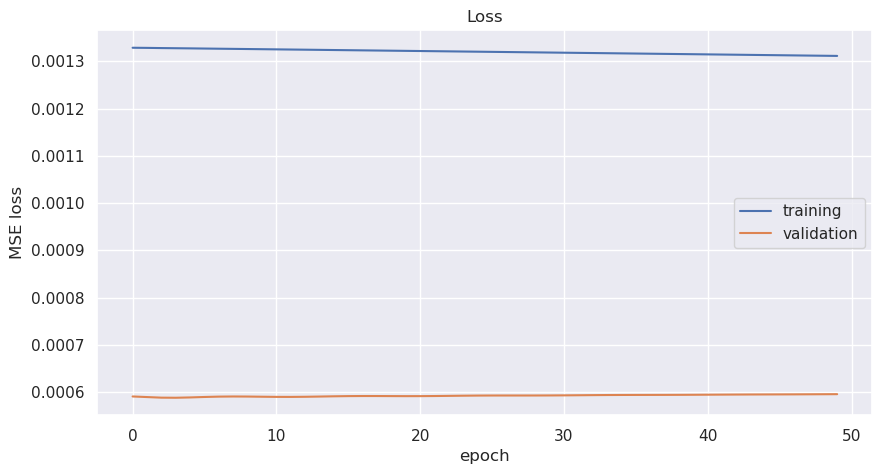

In [32]:
# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

# save figure
# plt.savefig(f'../../figs/{model_name}_loss.png', dpi=300)